# Course project

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp
import array_to_latex as a2l

In [2]:
SAVE_PATH = 'latex/graphics'

def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [3]:
from matplotlib import style
style.use('seaborn-v0_8-whitegrid')

## System state space

In [4]:
M = 10
m = 1
g = 9.8
l = 1

In [5]:
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m*g / M, 0],
    [0, 0, 0, 1],
    [0, 0, (M+m)*g / (M*l), 0]
])

B = np.array([
    [0],
    [1/M],
    [0],
    [1/(M*l)]
])

D = np.array([
    [0],
    [1/(M*l)],
    [0],
    [(M+m)/(M*m*l**2)]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

In [6]:
D

array([[0. ],
       [0.1],
       [0. ],
       [1.1]])

In [7]:
np.linalg.eigvals(A)

array([ 0.        ,  0.        ,  3.28329103, -3.28329103])

In [8]:
np.round(np.linalg.eig(A)[1],3)

array([[ 1.   , -1.   ,  0.026, -0.026],
       [ 0.   ,  0.   ,  0.087,  0.087],
       [ 0.   ,  0.   ,  0.29 , -0.29 ],
       [ 0.   ,  0.   ,  0.953,  0.953]])

In [9]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

Matrix([
[0, 1.0,                0,               0],
[0,   0,                0,               0],
[0,   0, -3.2832910318764,               0],
[0,   0,                0, 3.2832910318764]])

In [10]:
P

Matrix([
[1.0,   0, -0.0276884047215078, 0.0276884047215078],
[  0, 1.0,  0.0909090909090909, 0.0909090909090909],
[  0,   0,  -0.304572451936586,  0.304572451936586],
[  0,   0,                 1.0,                1.0]])

In [11]:
P.inv() @ B_sym

Matrix([
[                 0],
[0.0909090909090909],
[              0.05],
[              0.05]])

In [12]:
C @ P

Matrix([
[1.0, 0, -0.0276884047215078, 0.0276884047215078],
[  0, 0,  -0.304572451936586,  0.304572451936586]])

In [13]:
np.linalg.matrix_rank(np.concatenate([A-(0)*np.identity(4),C]))

4

In [14]:
np.linalg.matrix_rank(np.concatenate([A-(-3.28329103)*np.identity(4),B],axis=1))

4

In [15]:
sys_for_an = ctrl.ss(A, D, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([0.1])], [array([1.1])]], [[array([  1.  ,  -0.  , -10.78])], [array([  1.  ,  -0.  , -10.78])]])

In [16]:
sys_for_an = ctrl.ss(A, B, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([ 1.00000000e-01,  5.88418203e-16, -9.80000000e-01])], [array([0.1, 0. , 0. ])]], [[array([ 1.00000000e+00,  4.99600361e-15, -1.07800000e+01, -1.40229631e-14,
        1.45089866e-14])], [array([ 1.0000000e+00,  3.4622337e-15, -1.0780000e+01,  0.0000000e+00,
        0.0000000e+00])]])

In [17]:
def up_func(t, x, u, params):
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
non_lin_sys = ctrl.NonlinearIOSystem(up_func)
non_lin_sys.set_inputs(2)

In [18]:
time_1 = np.linspace(0,2,int(2/0.001))

In [19]:
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=[0,0,0.05,0])
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=[0,0,0.05,0],U=np.zeros((2,len(time_1))))

Linear

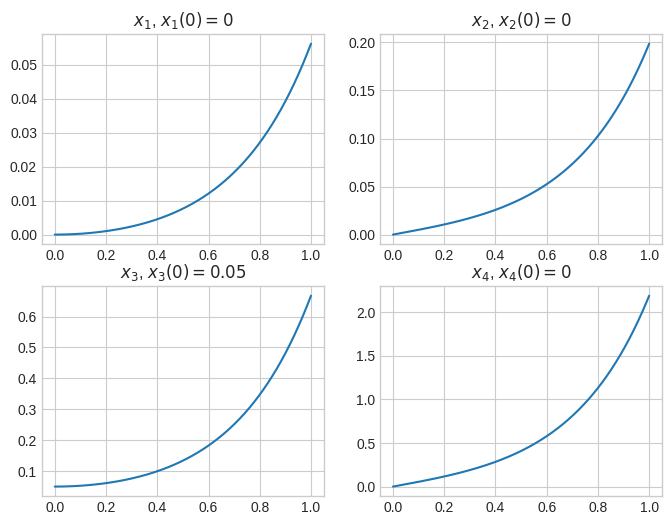

In [20]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

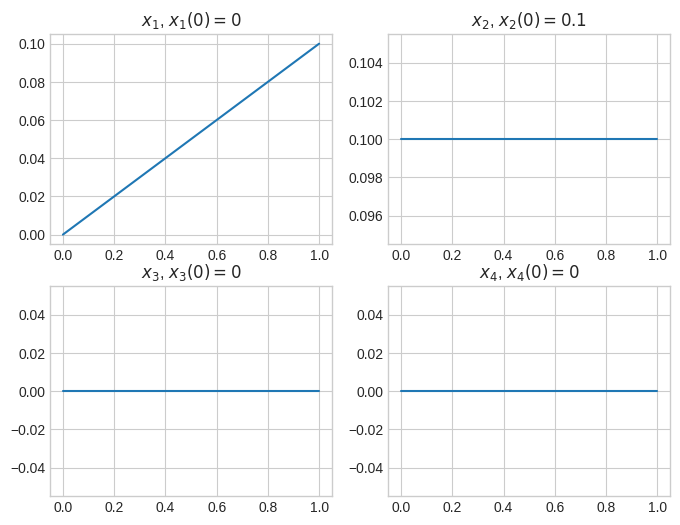

In [21]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

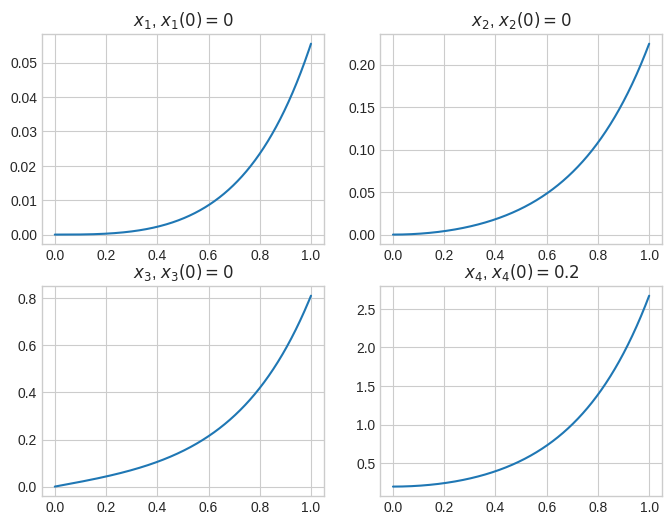

In [22]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

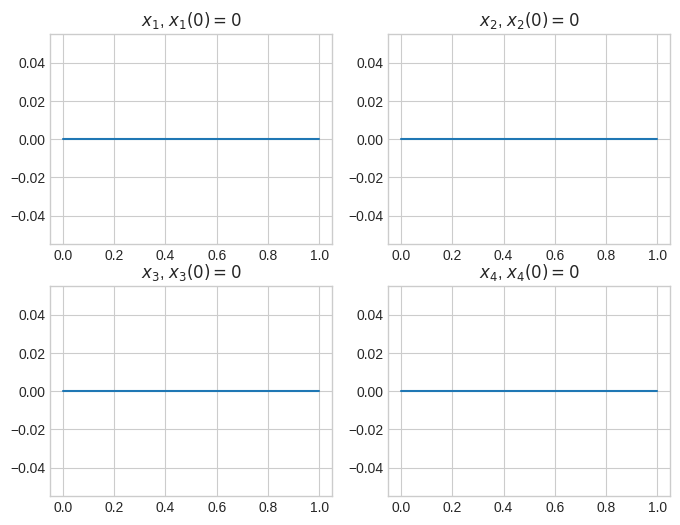

In [23]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

Non-linear

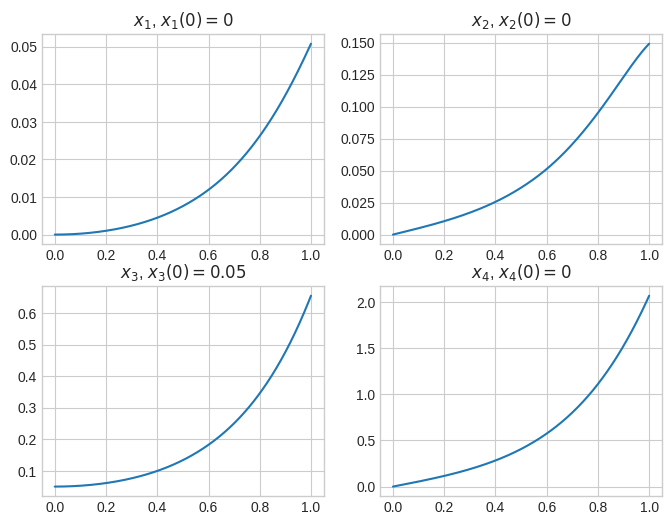

In [24]:
x0 = [0,0,0.05,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

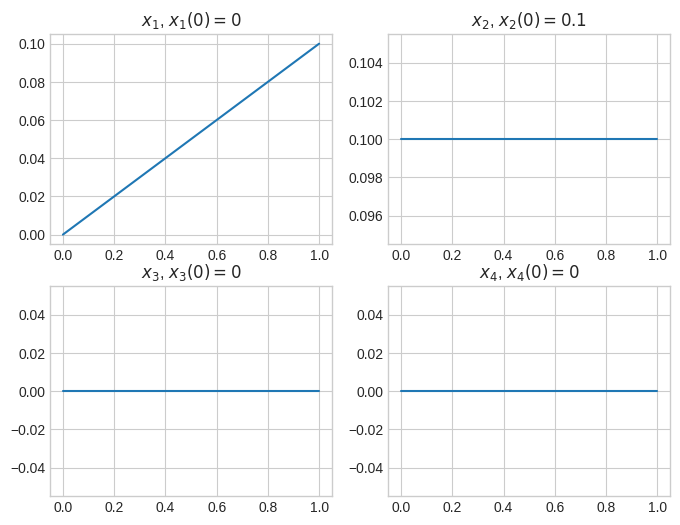

In [25]:
x0 = [0,0.1,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

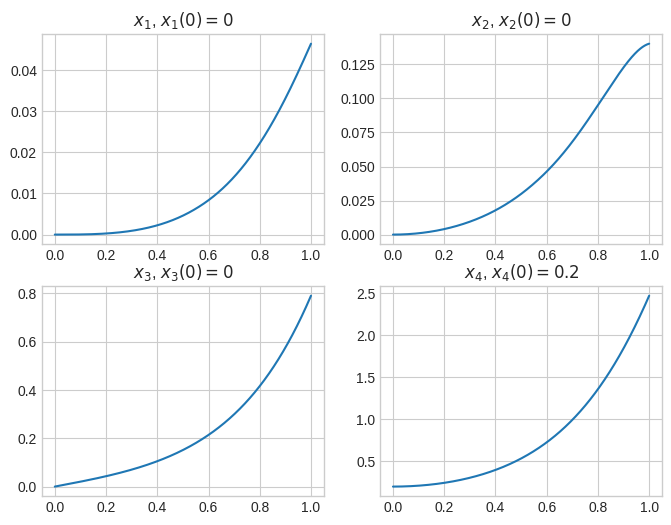

In [26]:
x0 = [0,0,0,0.2]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

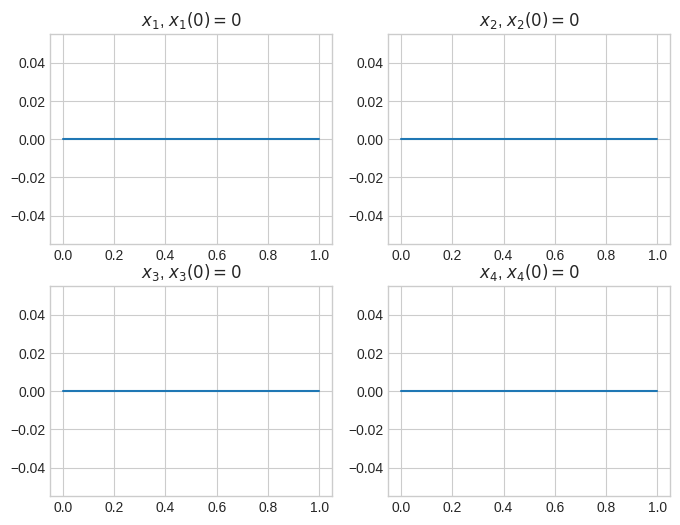

In [27]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

Comparison

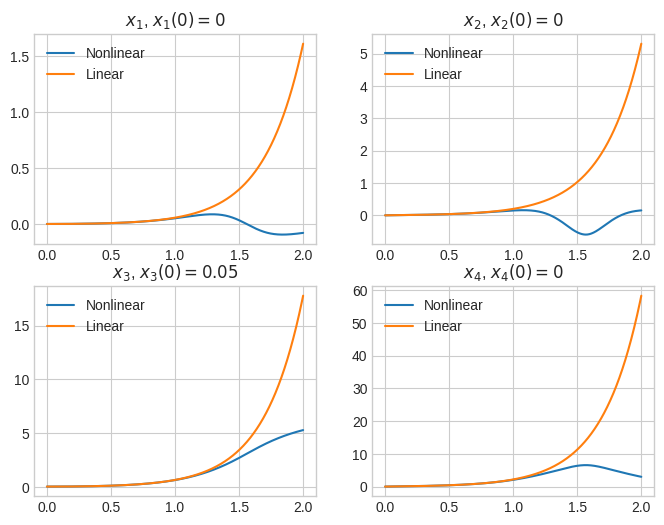

In [28]:
x0 = [0,0,0.05,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

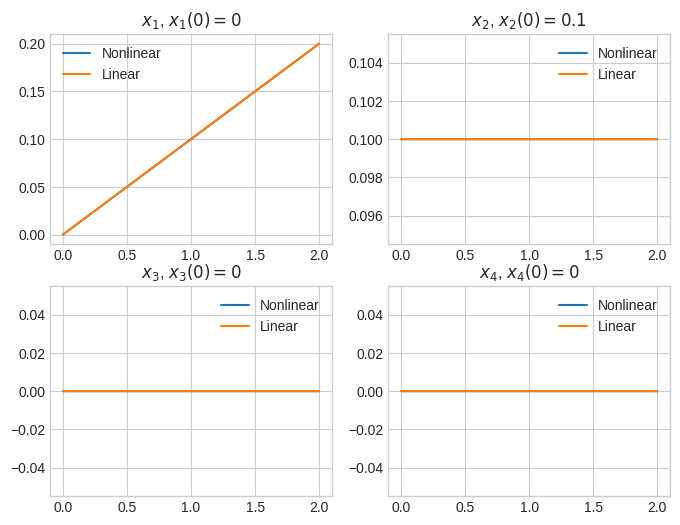

In [29]:
x0 = [0,0.1,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

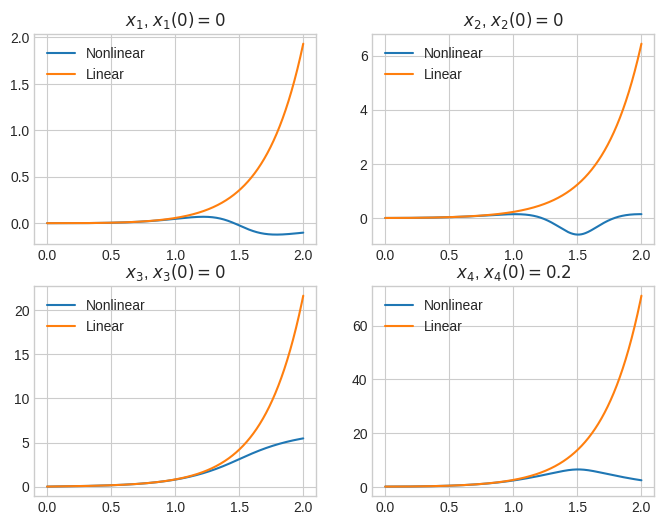

In [30]:
x0 = [0,0,0,0.2]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

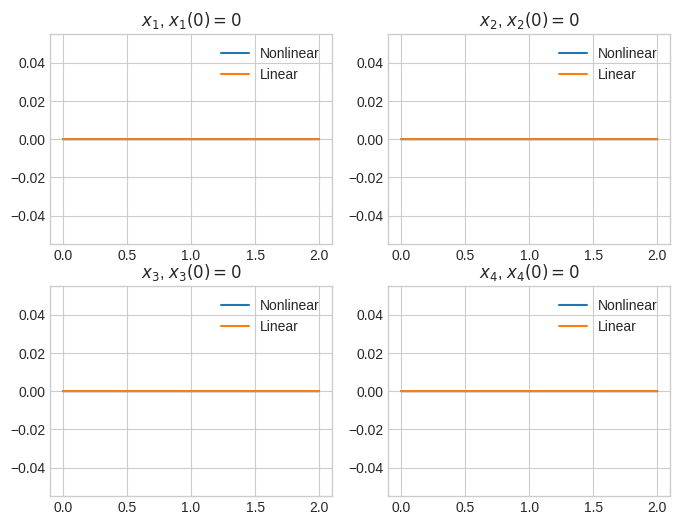

In [31]:
x0 = [0,0,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

## Modal control

In [32]:
def task3_get_K(A, B, G, Y):
    P= cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(A @ P - P @ G - B @ Y))
    prob = cp.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    K = - Y @ np.linalg.pinv(P.value)
    print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
    return K

def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}')
    ss = ctrl.ss(A + B@K, A*0, A*0, A*0)
    return ctrl.forced_response(ss, X0=x0, T=ts)

In [33]:
G = np.diag([-1, -2, -1.5, -2.5])
Y = np.ones((B.shape[1], A.shape[0]))
K = task3_get_K(A, B, G, Y)

Optimization error: 2.1787082495880606e-33, rankP = 4
\[K = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.50 & -2.00 & -1.50 & -1.00
\end{bmatrix}\]


In [34]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

In [35]:
def non_linear_compare_mod_control(ss_lin, ss_non_lin, x0, ts):
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        
        plt.savefig(f'{SAVE_PATH}/task3_1_{"_".join([str(x) for x in x0])}.jpg')

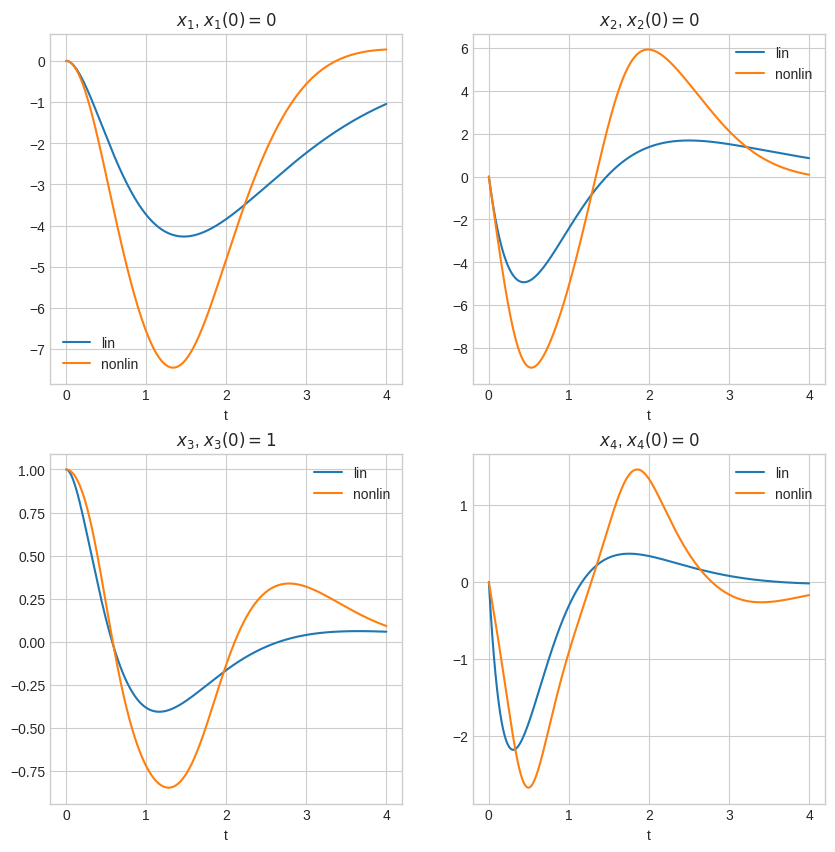

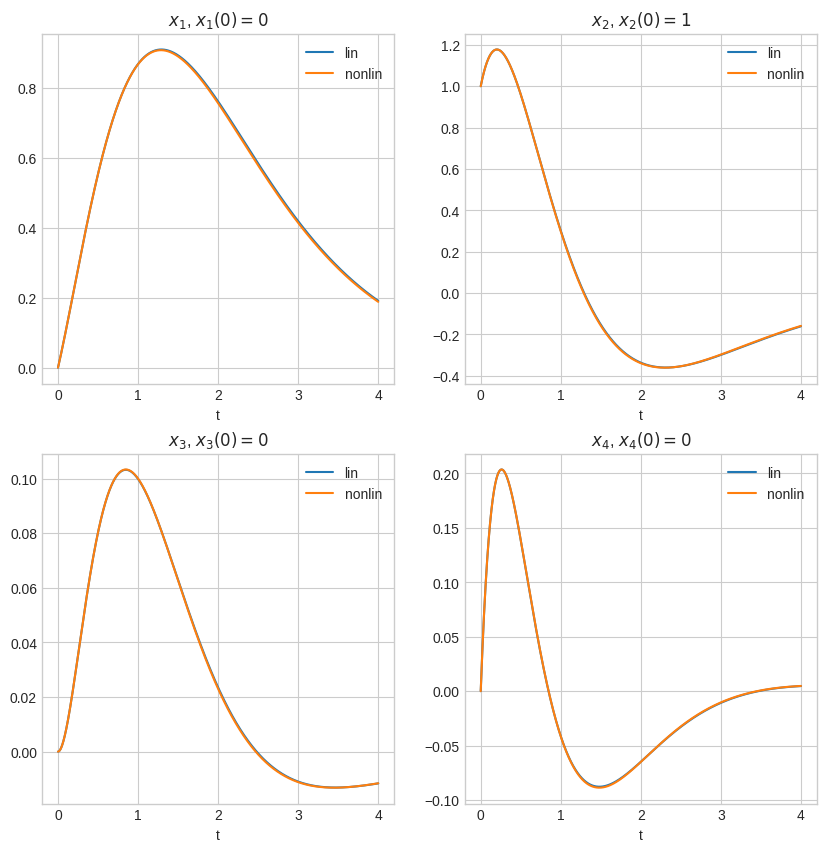

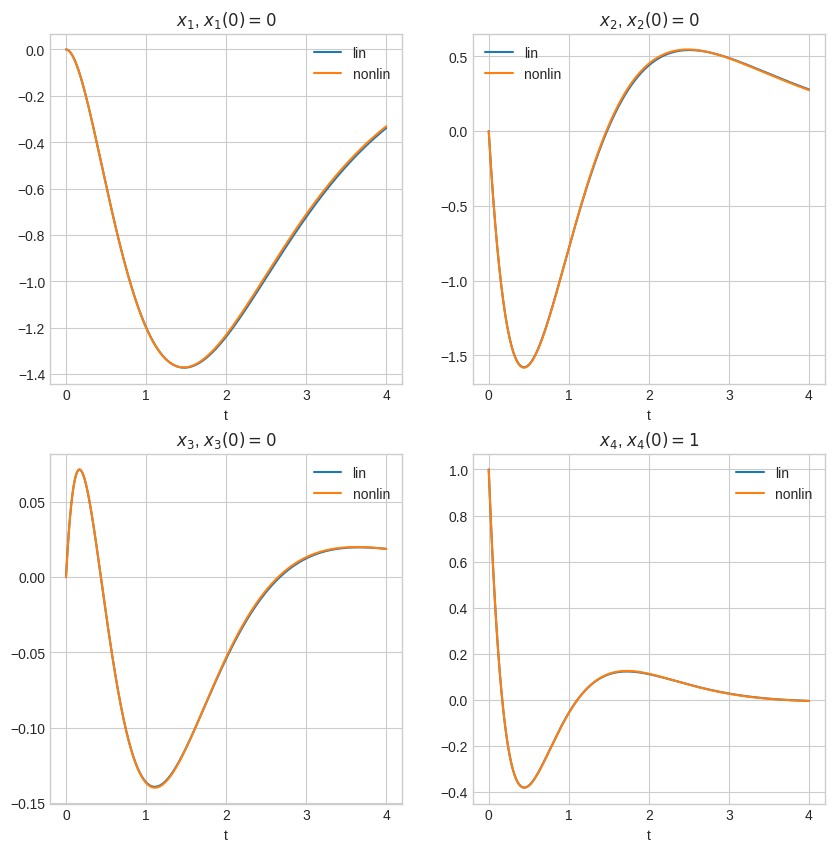

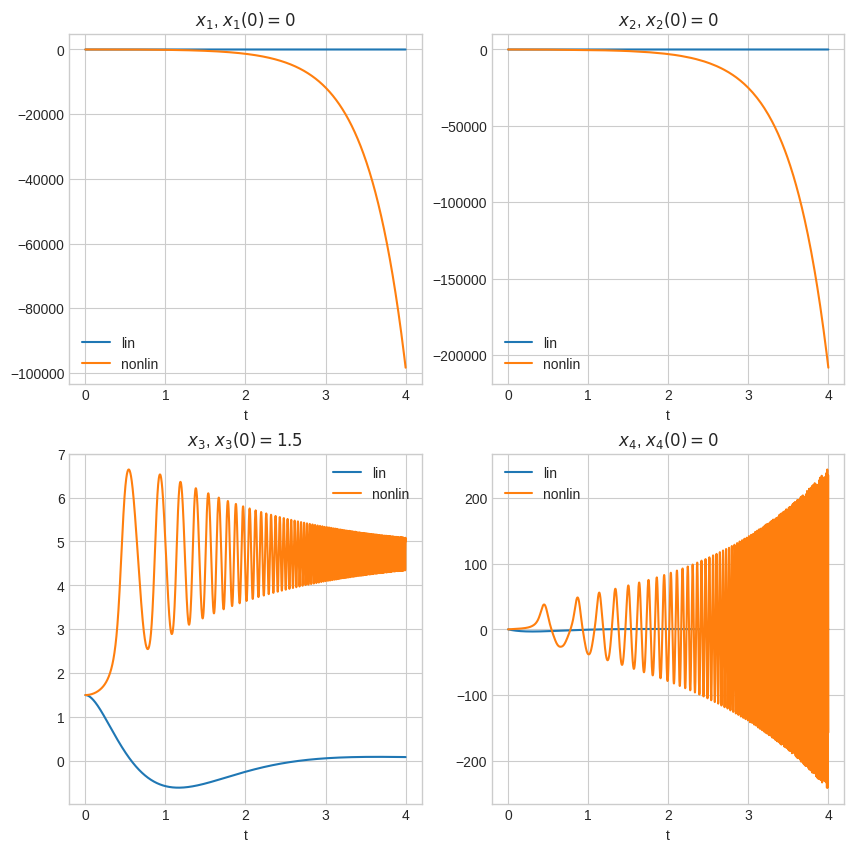

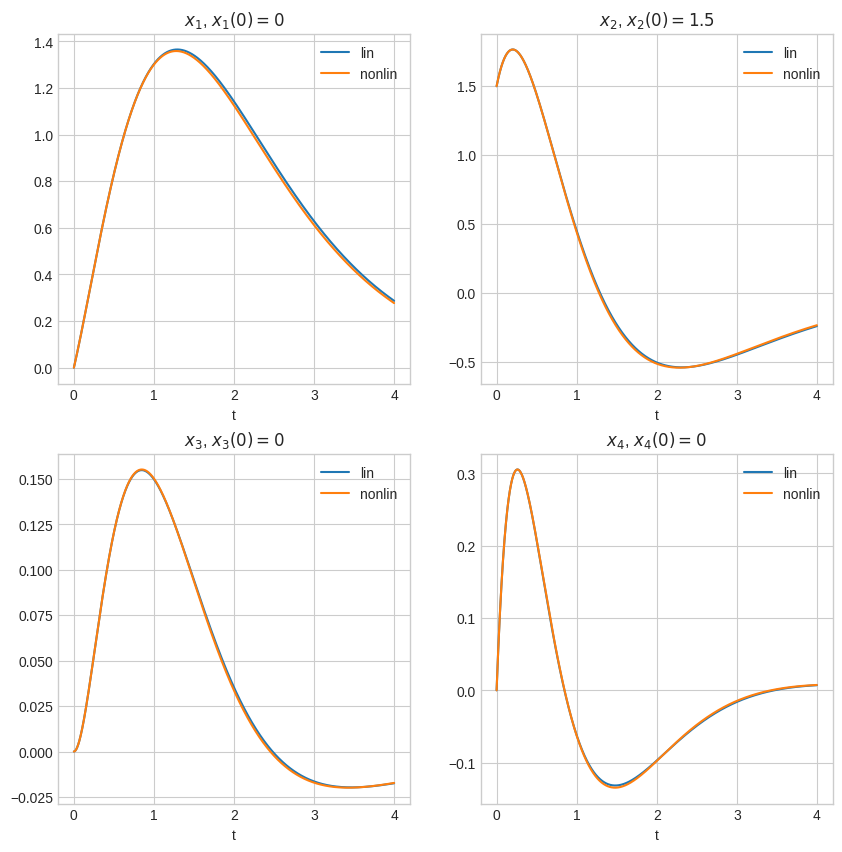

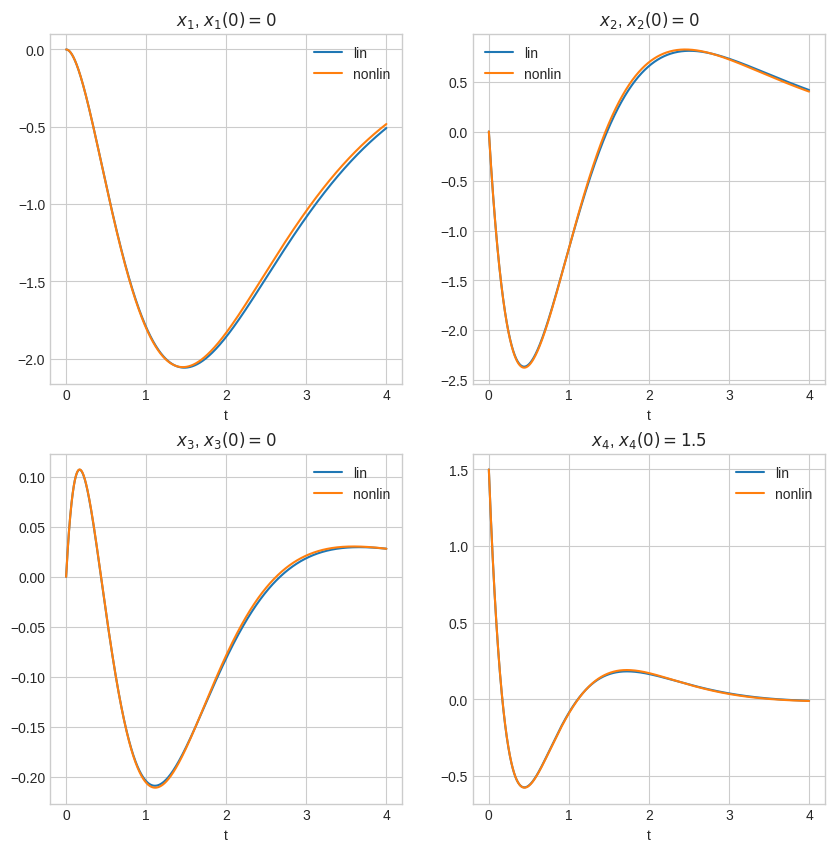

In [36]:
x0s = [[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1.5, 0], [0, 1.5, 0, 0], [0, 0, 0, 1.5]]
ts = get_t(4)
ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
for x0 in x0s:
    non_linear_compare_mod_control(ss_mod, ss_non_lin, x0, ts)

3.2

In [37]:
def task32_get_K(A, B, G, Y):
    P= cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(A @ P - P @ G - B @ Y))
    prob = cp.Problem(objective)
    err = prob.solve()
    assert err < 1, 'Not solved for K'
    K = - Y @ np.linalg.pinv(P.value)
    return K
Gs = [np.diag([-1, -2, -1.5, -2.5]), np.diag([-1, -2, -1.5, -2.5]) / 10, np.array([[-1, -1, 0, 0], [1, -1, 0, 0], [0, 0, -2, -2], [0, 0, 2, -2]])]

In [38]:
ts = get_t(4)
Y = np.ones((B.shape[1], A.shape[0]))
print('\\begin{center}\n    \\begin{tabular}{ c | c c c }')
print('$\sigma G$ & $\max x$ & $\max \\varphi$ & $\max u$ \\\\')
for G in Gs:
    K = task32_get_K(A, B, G, Y)
    x0 = [0, 0, 1, 0]
    ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin.set_inputs(2)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    print(f'        ${a2l.to_ltx(np.linalg.eigvals(G), print_out=False)}$ & {round(np.abs(resp_non_lin.states[0]).max(), 1)} & {round(np.abs(resp_non_lin.states[3]).max(), 1)} & {round(np.abs(K @ resp_non_lin.states).max(), 1)} \\\\')
print("    \end{tabular}\n\end{center}")

\begin{center}
    \begin{tabular}{ c | c c c }
$\sigma G$ & $\max x$ & $\max \varphi$ & $\max u$ \\
        $\begin{bmatrix}
 -1.00 & -2.00 & -1.50 & -2.50
\end{bmatrix}$ & 7.4 & 2.7 & 293.0 \\
        $\begin{bmatrix}
 -0.10 & -0.20 & -0.15 & -0.25
\end{bmatrix}$ & 115.7 & 13.1 & 723.0 \\
        $\begin{bmatrix}
 -1.00 + 1.00j & -1.00 + -1.00j & -2.00 + 2.00j & -2.00 + -2.00j
\end{bmatrix}$ & 34887.2 & 201.4 & 2938438.6 \\
    \end{tabular}
\end{center}


3.3

In [39]:
def task3_get_L(A, C, G, Y):
    Q = cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cp.Problem(objective)
    assert prob.solve() < 1, 'Not solved'
    return np.linalg.pinv(Q.value) @ Y

def up_func_L(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)

In [40]:
Gs = [np.diag([-1, -2, -1.5, -2.5]), np.diag([-1, -2, -1.5, -2.5]) / 10, np.array([[-1, -1, 0, 0], [1, -1, 0, 0], [0, 0, -2, -2], [0, 0, 2, -2]])]

In [41]:
ts = get_t(10)
Y = np.ones((B.shape[1], A.shape[0]))
G = Gs[0]
K = task32_get_K(A, B, G, Y)
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))
L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
print(f'\[L = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')
print(f'\[Y = {a2l.to_ltx(new_y, print_out=False)}\]')

ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
ss_non_lin_obs.set_inputs(2)

\[L = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -2.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -1.50 &  0.00\\
  0.00 &  0.00 &  0.00 & -2.50
\end{bmatrix}\]
\[Y = \begin{bmatrix}
  1.00 &  1.00\\
  1.00 &  1.00\\
  1.00 &  1.00\\
  1.00 &  1.00
\end{bmatrix}\]


In [42]:
x0s = [[0.1, 0, 0.1, 0], [0, 0, 1, 0], [1, 0, 0, 0]]
for x0 in x0s:
    x0 = np.array(x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
        plt.savefig(f'{SAVE_PATH}/task3_3_{x0[0]}_{x0[2]}.jpg')
    plt.close()

3.4

In [43]:
x0 = np.array(x0s[0])
resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
for new_g in Gs:
    L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
    print(f'\[L = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')

    ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
    ss_non_lin_obs.set_inputs(2)
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$\sigma \Gamma = [{"; ".join([str(np.round(x, 1)) for x in np.linalg.eigvals(new_g)])}]$')
        plt.savefig(f'{SAVE_PATH}/task3_4_{"_".join([str(x) for x in np.linalg.eigvals(new_g)])}.jpg')
    plt.close()
    

\[L = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -2.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -1.50 &  0.00\\
  0.00 &  0.00 &  0.00 & -2.50
\end{bmatrix}\]
\[L = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -0.10 &  0.00 &  0.00 &  0.00\\
  0.00 & -0.20 &  0.00 &  0.00\\
  0.00 &  0.00 & -0.15 &  0.00\\
  0.00 &  0.00 &  0.00 & -0.25
\end{bmatrix}\]
\[L = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 & -1.00 &  0.00 &  0.00\\
  1.00 & -1.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -2.00 & -2.00\\
  0.00 &  0.00 &  2.00 & -2.00
\end{bmatrix}\]


3.5

In [44]:
def up_func_K_L(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    return np.hstack((dx, dxh))

In [45]:
new_y = np.ones((A.shape[0], C.shape[0]))
L = task3_get_L(A, C, Gs[0], new_y).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task32_get_K(A, B, Gs[0], Y)
x0 = np.array(x0s[0])

In [46]:
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')

\[L = \begin{bmatrix}
  1.05 &  1.05\\
 -1.74 & -1.74\\
 -8.05 & -8.05\\
 -26.79 & -26.79
\end{bmatrix}\]
\[K = \begin{bmatrix}
  7.65 &  19.64 & -292.95 & -89.64
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 & -1.00 &  0.00 &  0.00\\
  1.00 & -1.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -2.00 & -2.00\\
  0.00 &  0.00 &  2.00 & -2.00
\end{bmatrix}\]


In [47]:
def nonlin_modal_full(x0, ts = get_t(10)):
    ss_non_lin = ctrl.NonlinearIOSystem(up_func_K_L, params={"K": K, "L": L, 'C': C})
    ss_non_lin.set_inputs(2)
    resp_non_lin_by_output = ctrl.input_output_response(ss_non_lin, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=C @ resp_non_lin.states[:,:len(ts)])
    for i in range(4):
        plt.plot(ts, resp_non_lin_by_output.states[i], label=f'$x_{i}$') 
        plt.xlabel('t') 
        plt.legend() 
        plt.savefig(f'{SAVE_PATH}/task3_5_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

In [48]:
x0s[0]

[0.1, 0, 0.1, 0]

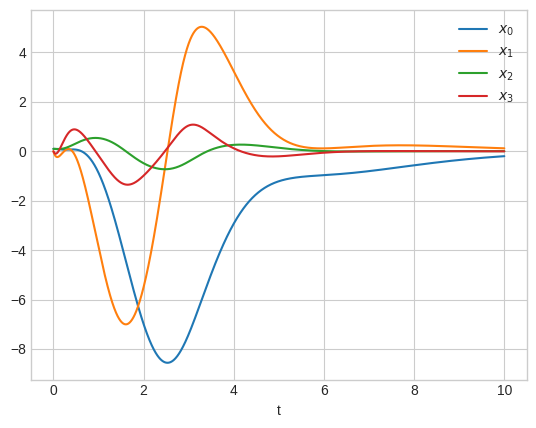

In [49]:
nonlin_modal_full(np.array(x0s[0]))

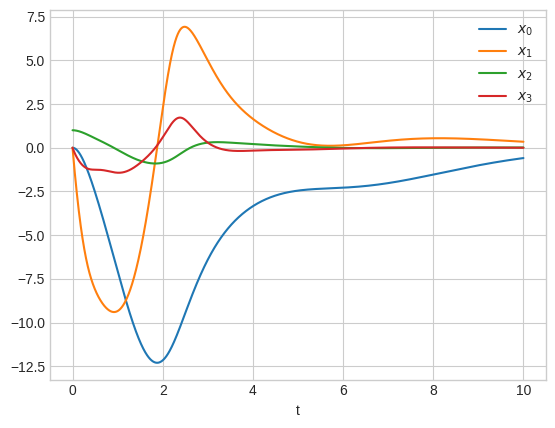

In [50]:
nonlin_modal_full(np.array(x0s[1]))

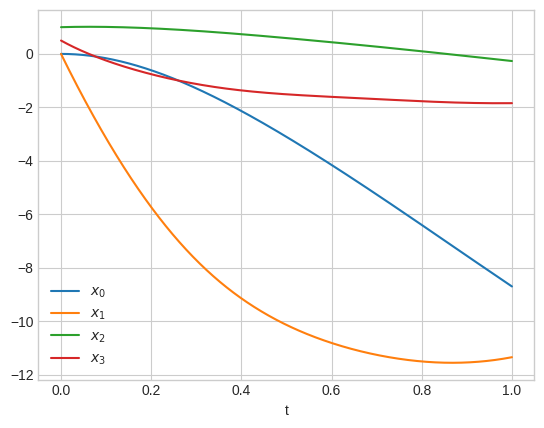

In [51]:
nonlin_modal_full(np.array([0, 0, 1, 0.5]),ts=get_t(1))

## Task 4

In [52]:
def task4_get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value) 

def task4_get_K_LMI_mu(a, b, alpha, x0, mu=None):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    if mu is None:
        mu_ = cp.Variable((1,1))
    else:
        mu_ = mu
    sub1 = cp.bmat([
        [P, x0],
        [x0.T, [[1]]]
    ])
    if mu is None:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, mu_]
        ])
    else:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, [[mu_*mu_]]]
        ])
    prob = cp.Problem(cp.Maximize(0) if mu is not None else cp.Minimize(mu_),
                      [P >> np.eye(4), 
                       P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0,
                       sub1 >> 0, sub2 >> 0])
    res = prob.solve(solver="CLARABEL")
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value), np.sqrt(res)

def task4_get_L_LMI(a, c, alpha):
    Q = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((c.shape[1],c.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[Q >> np.eye(4), 
                                      a.T@Q + Q@A + 2*alpha*Q + c.T@Y.T + Y@c << 0])
    prob.solve()
    # print(Q.value, Y.value)
    return np.linalg.inv(Q.value) @ Y.value

### Task 4.1

In [53]:
alpha = 1

In [54]:
K = task4_get_K_LMI(A, B, alpha)
K

array([[  95.11574037,  114.09047559, -732.80952701, -172.27270022]])

In [55]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]


In [56]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
ss_non_lin_4_1 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin_4_1.set_inputs(2)

In [57]:
def task4_1_non_linear_compare_mod_control(ss_lin, ss_non_lin, x0, ts):
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], "--", label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        
        plt.savefig(f'{SAVE_PATH}/task4_1_{"_".join([str(x) for x in x0])}.jpg')

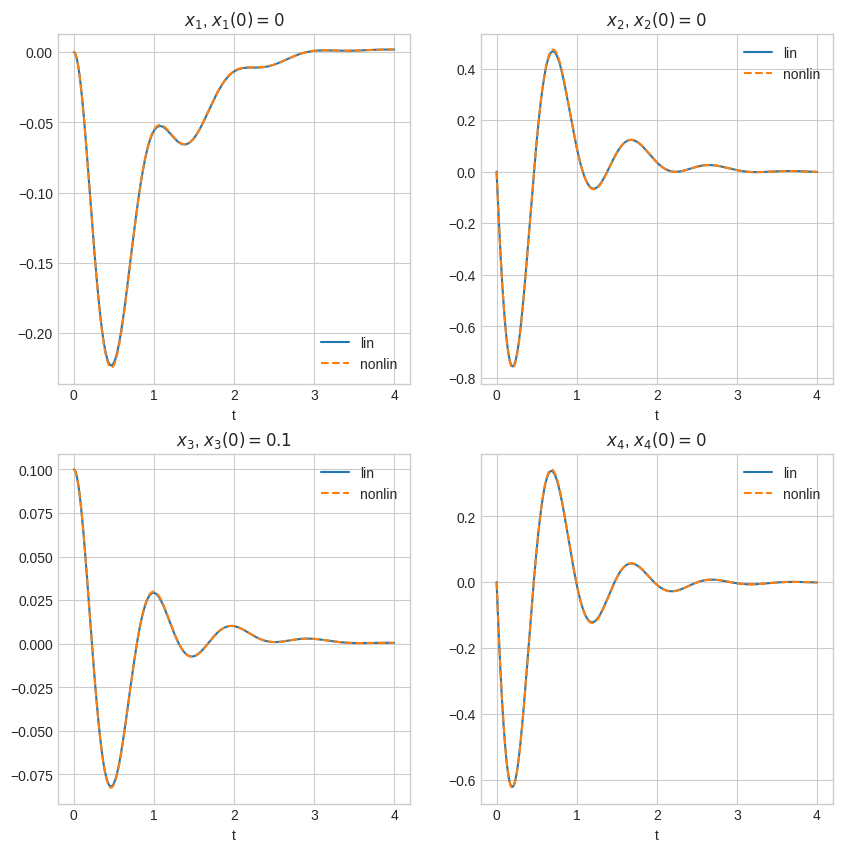

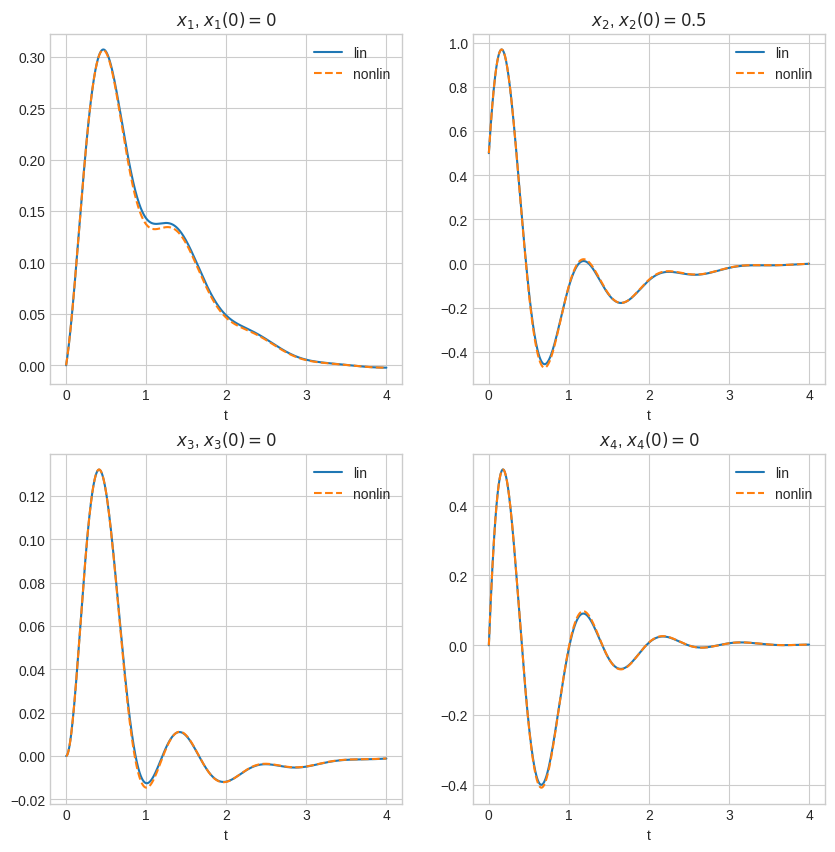

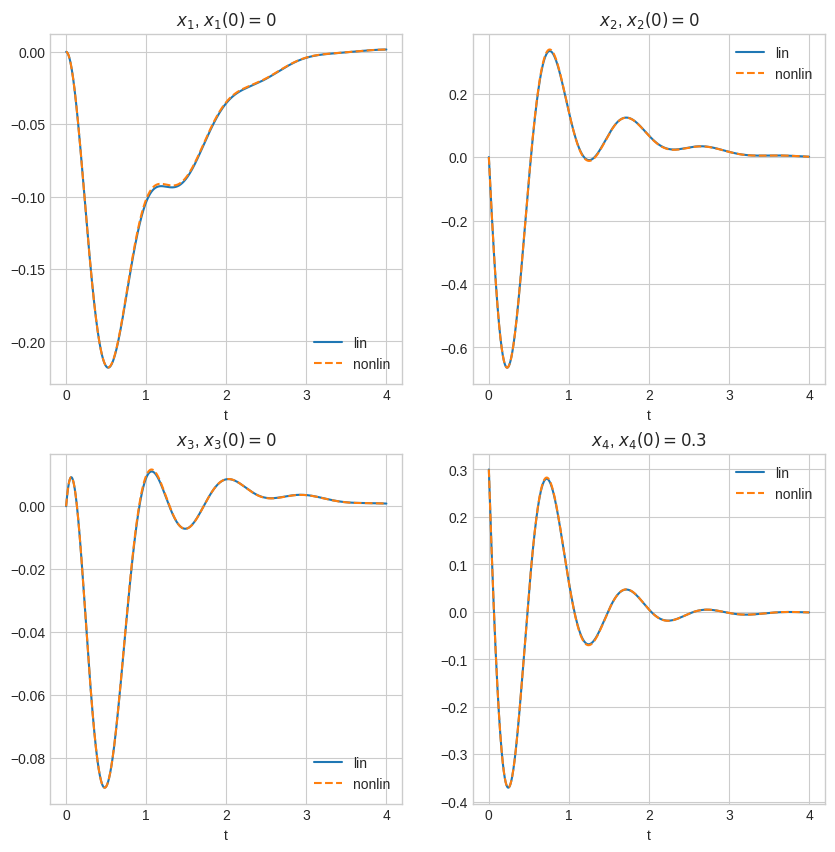

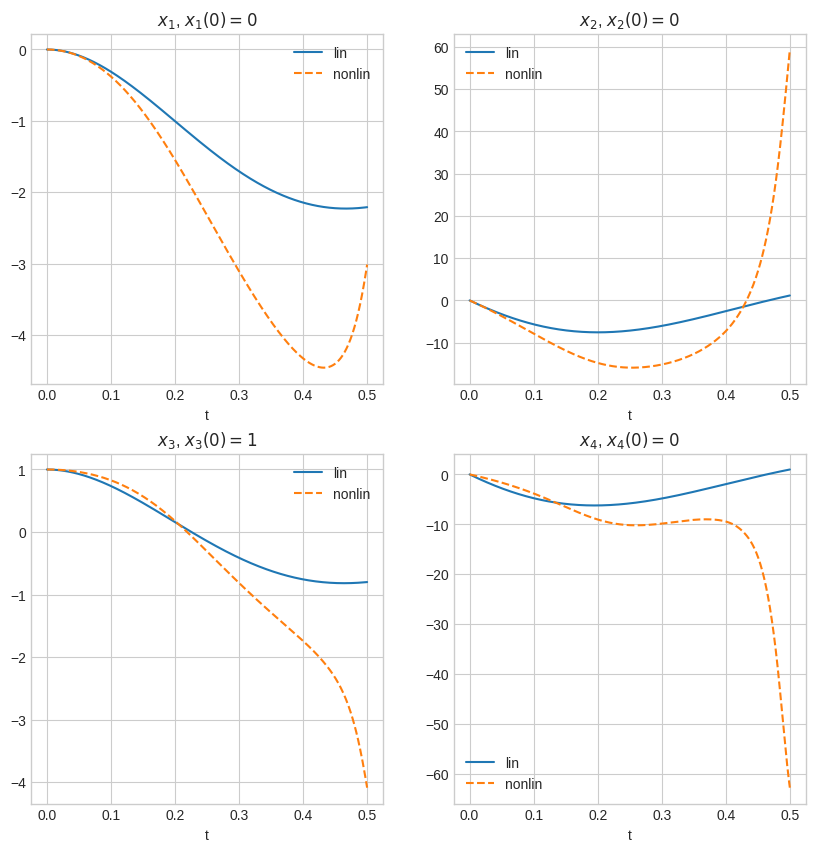

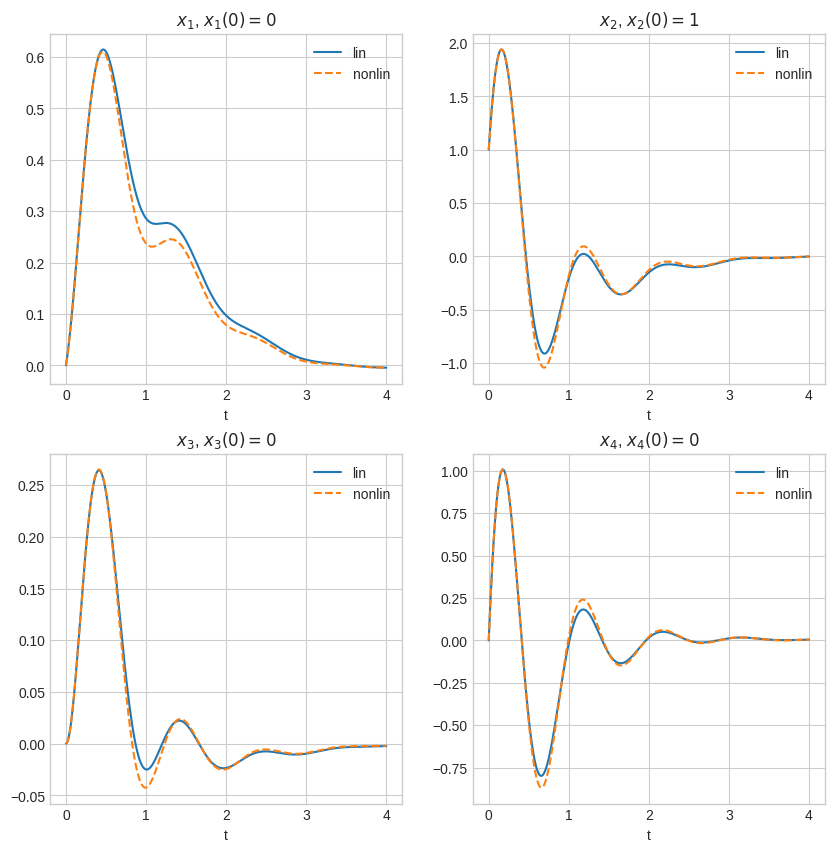

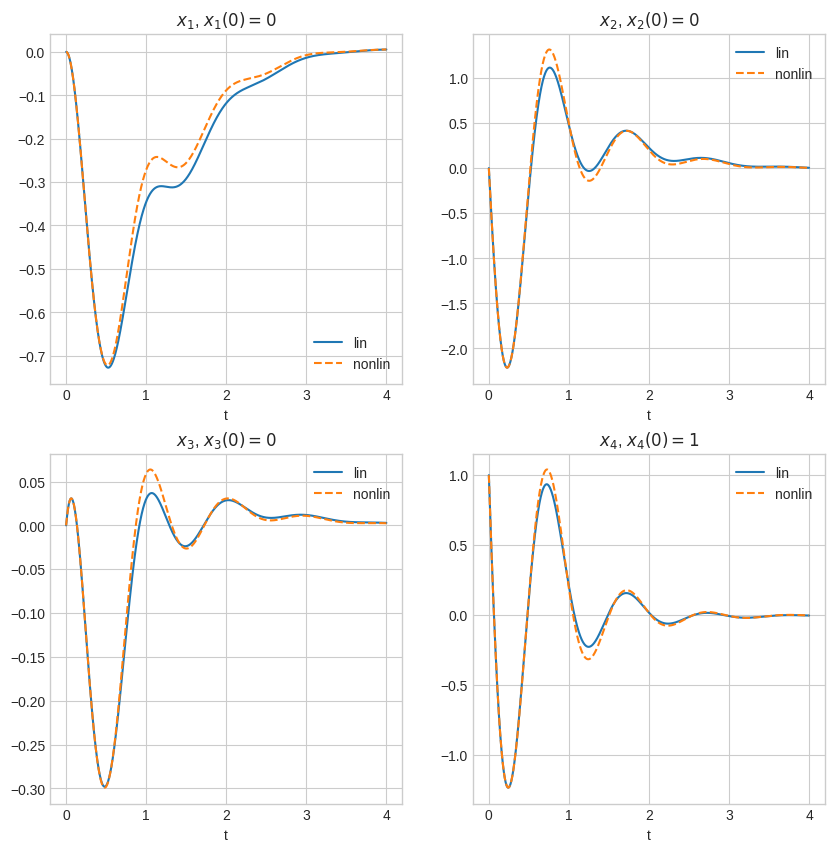

In [58]:
x0s = [
    [0, 0, 0.1, 0], [0, 0.5, 0, 0], [0, 0, 0, 0.3],
    [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]
]
ts = get_t(4)
ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
for i, x0 in enumerate(x0s):
    if i == 3:
        ts = get_t(0.5)
    else:
        ts = get_t(4)
    task4_1_non_linear_compare_mod_control(ss_mod, ss_non_lin_4_1, x0, ts)

### Task 4.2

In [59]:
def task4_2_non_linear_compare_alphas_control(x0, ts):
    alphas = [0.1, 0.8, 1.5]
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    us = []
    for alpha in alphas:
        K = task4_get_K_LMI(A, B, alpha)
        print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
        print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
        ss_non_lin_4_2 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
        ss_non_lin_4_2.set_inputs(2)
        resp_non_lin = ctrl.input_output_response(ss_non_lin_4_2, T=ts, X0=x0, U=np.zeros((2, len(ts))))
        us.append((K@resp_non_lin.states).reshape(-1))
        for i in range(4):
            ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
            ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label=f"$\\alpha={alpha}$") 
            ax[i//2, i%2].set_xlabel('t') 
            ax[i//2, i%2].grid(True) 
            ax[i//2, i%2].legend() 
            
    plt.savefig(f'{SAVE_PATH}/task4_2_{"_".join([str(x) for x in x0])}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}")
    plt.plot(ts, us[0], label=f"$\\alpha={alphas[0]}$")
    plt.plot(ts, us[1], label=f"$\\alpha={alphas[1]}$")
    plt.plot(ts, us[2], label=f"$\\alpha={alphas[2]}$")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_2_u_{"_".join([str(x) for x in x0])}.jpg')

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


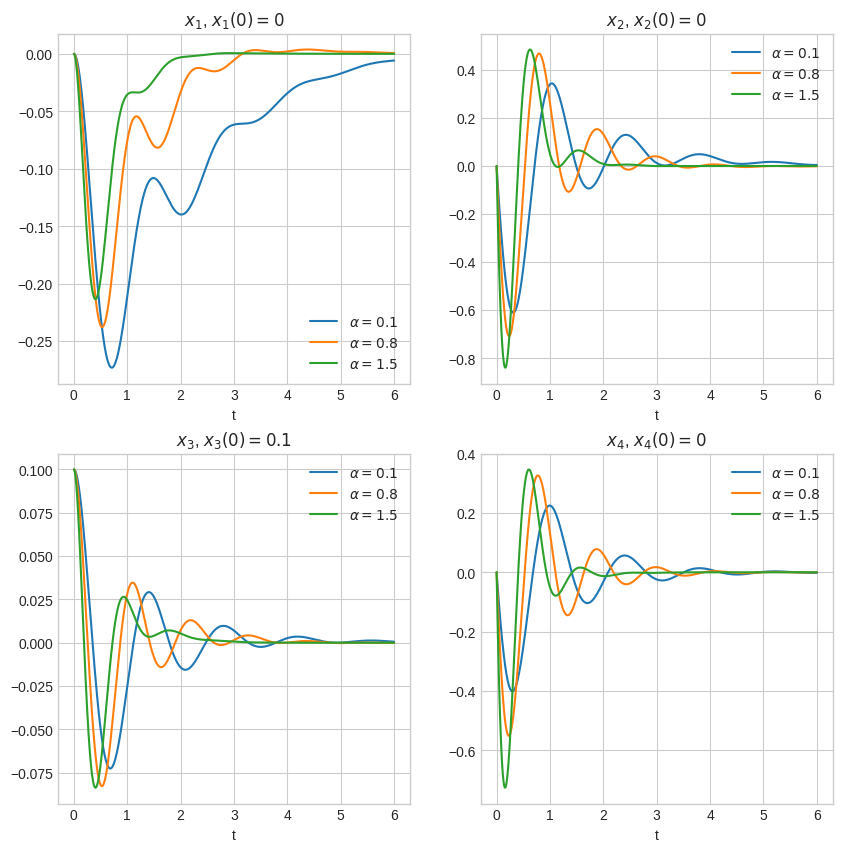

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


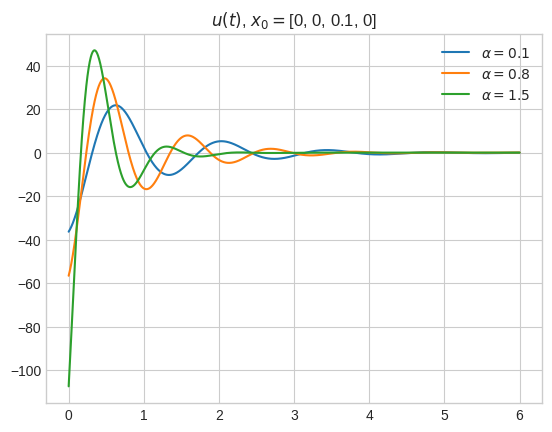

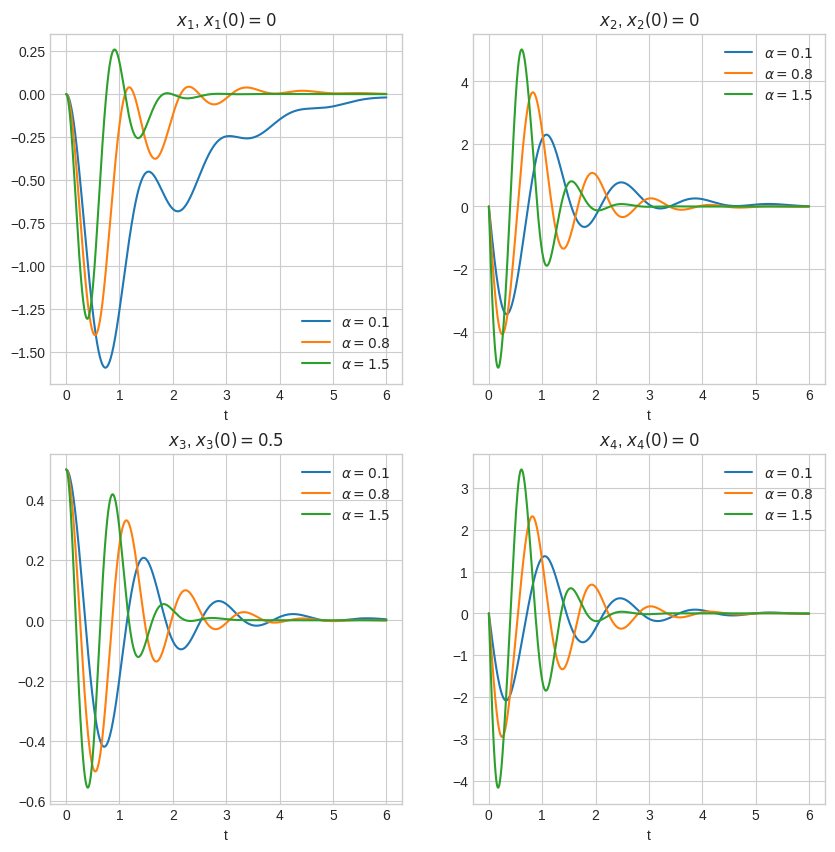

\[K = \begin{bmatrix}
  12.96 &  30.93 & -363.52 & -64.20
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -0.97 + 4.48j & -0.97 + -4.48j & -0.69 + 0.35j & -0.69 + -0.35j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  53.35 &  71.67 & -566.01 & -116.08
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.25 + 5.70j & -1.25 + -5.70j & -0.97 + 0.76j & -0.97 + -0.76j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  222.89 &  215.06 & -1074.55 & -304.71
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -2.62 + 6.61j & -2.62 + -6.61j & -1.86 + 0.93j & -1.86 + -0.93j
\end{bmatrix}\]


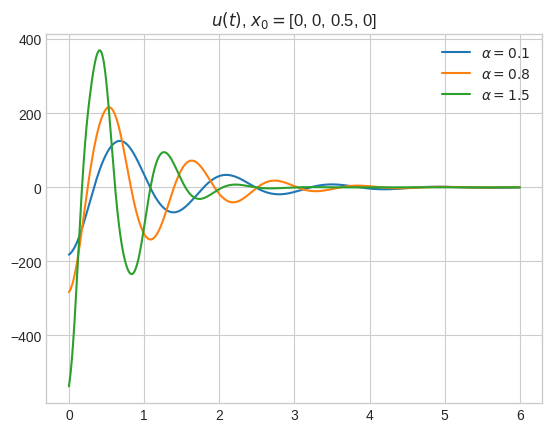

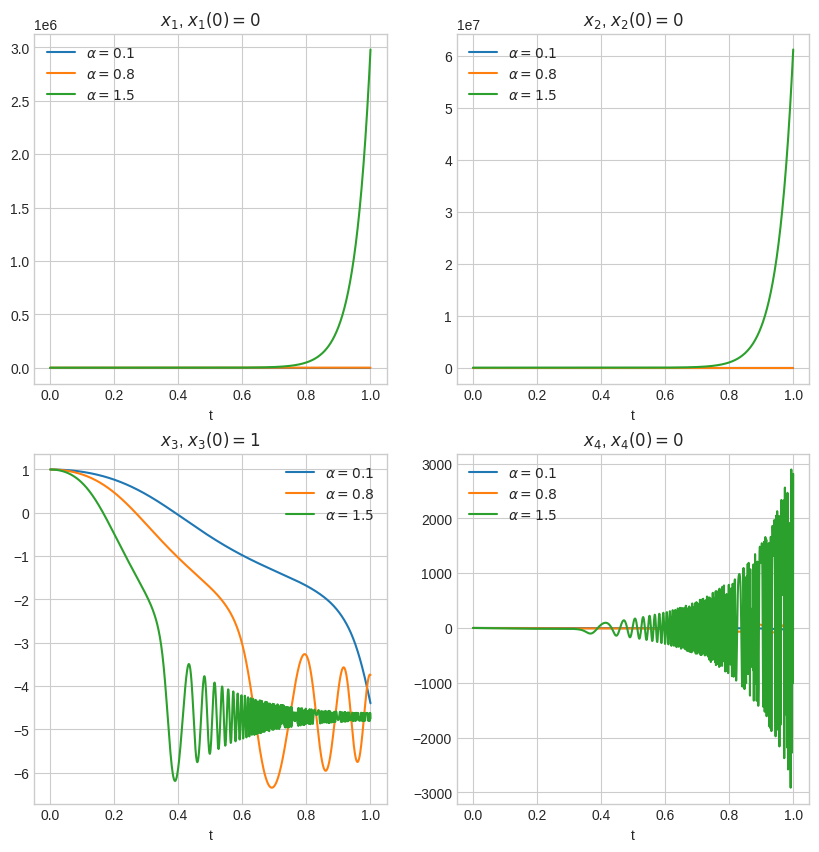

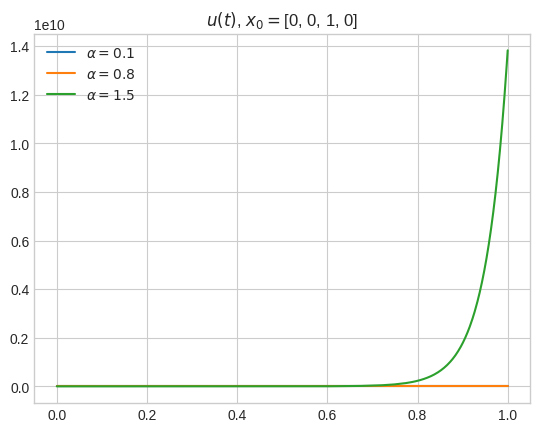

In [60]:
x0s = [
    [0, 0, 0.1, 0], [0, 0, 0.5, 0], [0, 0, 1, 0]
]
ts = get_t(6,0.005)
for i, x0 in enumerate(x0s):
    if i == 2:
        ts = get_t(1,0.001)
    task4_2_non_linear_compare_alphas_control(x0, ts)

### Task 4.3

In [61]:
def task4_3_non_linear_compare_alphas_control(alpha, ts):
    x0 = np.array([0, 0, 0.5, 0])
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    K, mu = task4_get_K_LMI_mu(A, B, alpha,x0.reshape((4,1)))
    print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
    ss_non_lin_4_3 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin_4_3.set_inputs(2)
    
    ss_lin = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin_4_3, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    fig.suptitle(f"$\\alpha={alpha}$")
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i],label="nonlin") 
        ax[i//2, i%2].plot(ts, resp.states[i],label="linear") 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
            
    plt.savefig(f'{SAVE_PATH}/task4_3_{alpha}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}, $\\alpha={alpha}$")
    plt.plot(ts, (K@resp_non_lin.states).reshape(-1), label="nonlin")
    plt.plot(ts, (K@resp.states).reshape(-1), label="linear")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_3_u_{alpha}.jpg')

In [62]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


\[K = \begin{bmatrix}
  0.16 &  1.74 & -122.85 & -37.57
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -0.10 + 0.69j & -0.10 + -0.69j & -0.10 + 0.00j
\end{bmatrix}\]


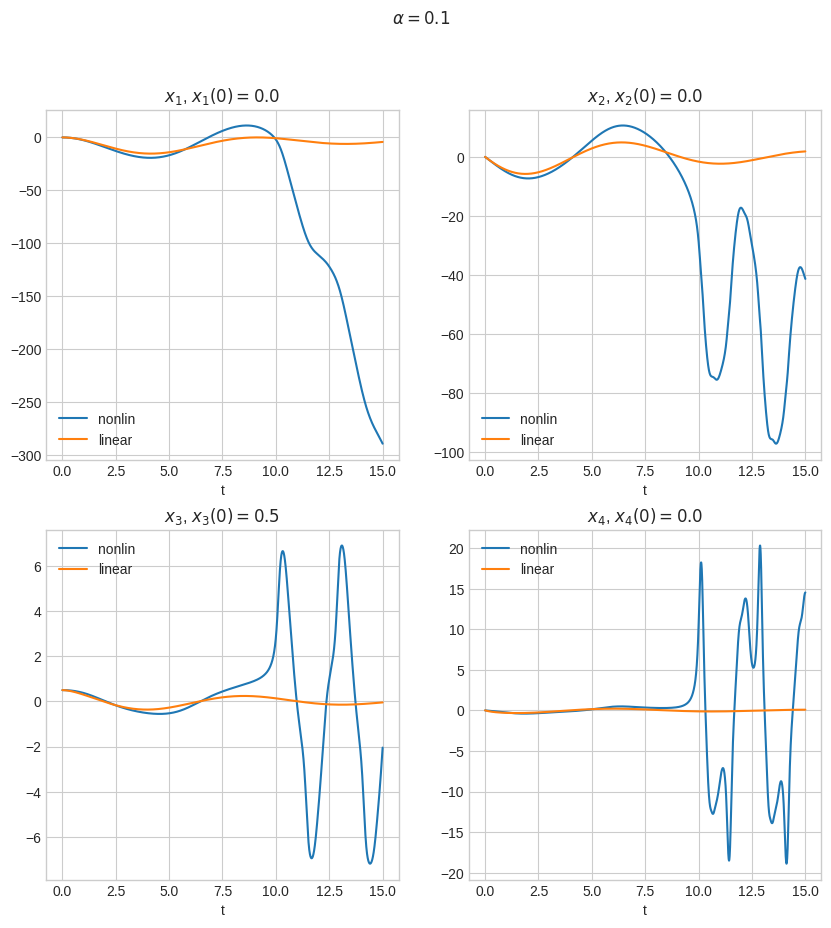

\[K = \begin{bmatrix}
  4.79 &  12.71 & -195.44 & -60.54
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -0.50 + 1.62j & -0.50 + -1.62j & -0.50 + 0.00j
\end{bmatrix}\]


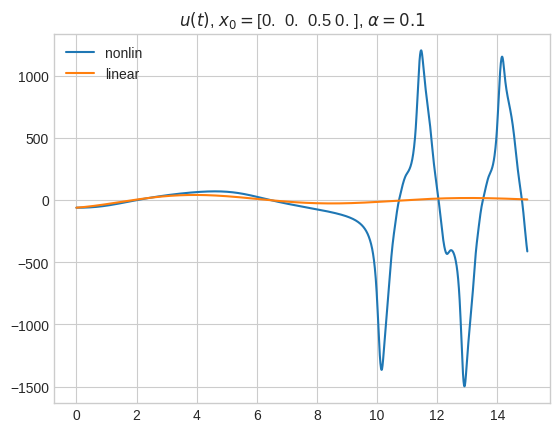

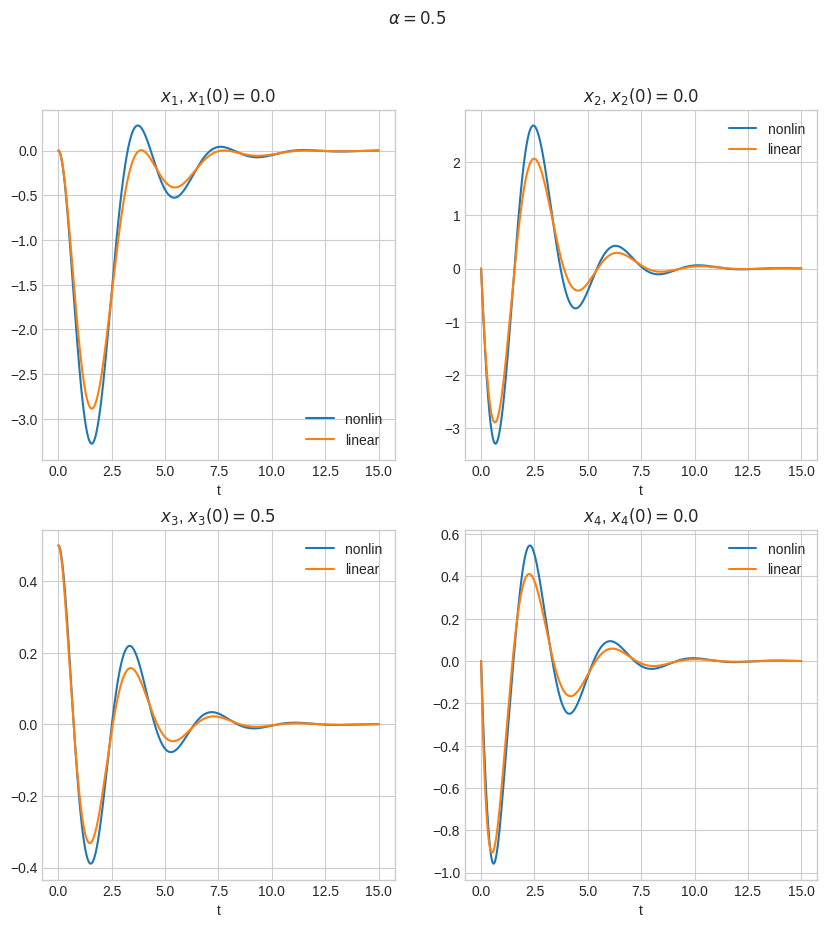

/home/vladislav/.pyenv/versions/3.10.11/envs/control/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


\[K = \begin{bmatrix}
  22.91 &  36.58 & -317.60 & -99.41
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.28 + 0.00j & -1.00 + 2.42j & -1.00 + -2.42j & -1.00 + 0.00j
\end{bmatrix}\]


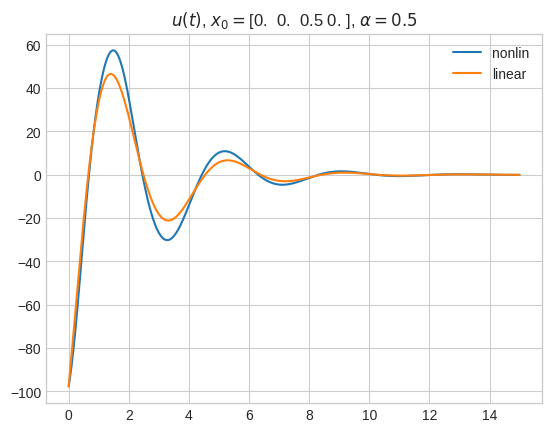

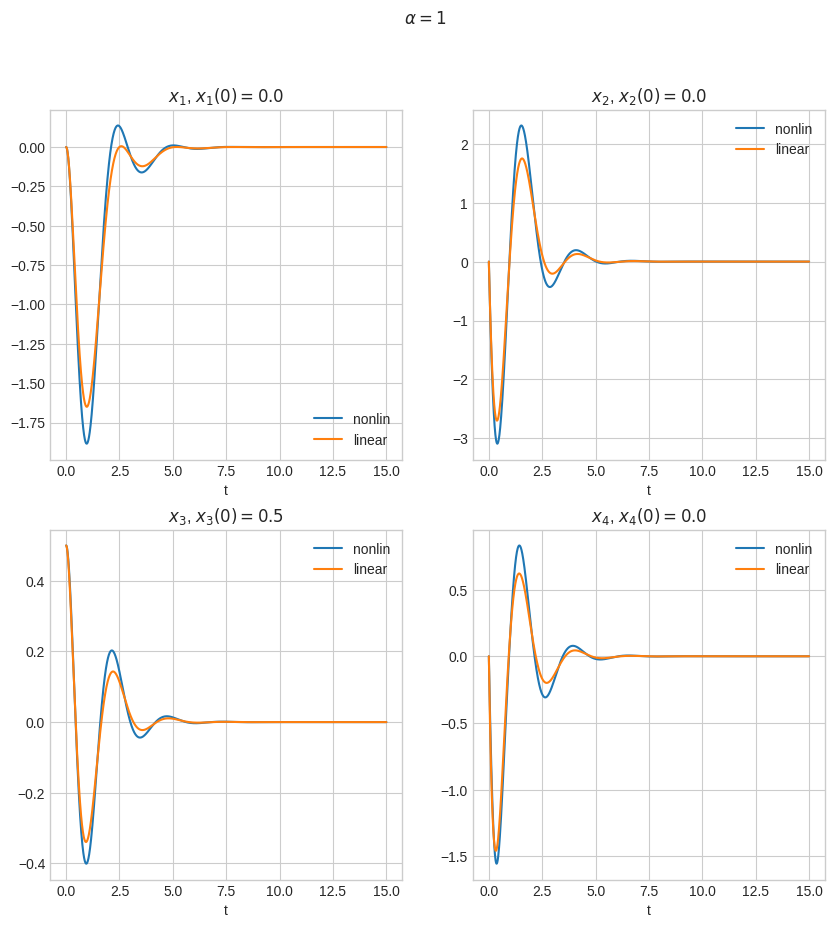

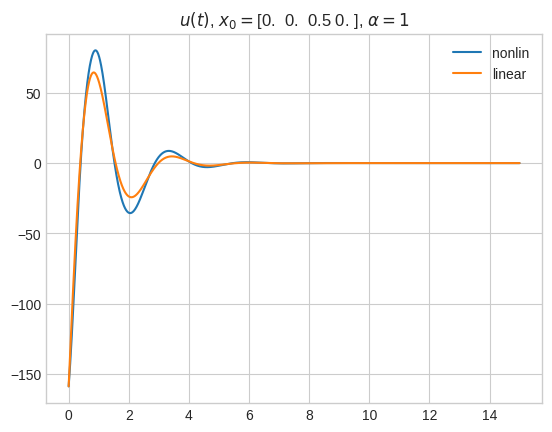

In [63]:
alphas = [
    0.1, 0.5, 1
]
ts = get_t(15,0.005)
for i, alpha in enumerate(alphas):
    # if i == 2:
    #     ts = get_t(1,0.001)
    task4_3_non_linear_compare_alphas_control(alpha, ts)

### Task 4.4

In [64]:
alpha

1

In [65]:
L = task4_get_L_LMI(A, C, alpha)
L

array([[ -4.44718497,  -0.61096929],
       [ -8.84781376,  -2.05816069],
       [  0.61096088,  -4.44730986],
       [  1.07814659, -19.62811224]])

In [66]:
np.linalg.eigvals(A + L@C)

array([-2.29370959+2.30590555j, -2.29370959-2.30590555j,
       -2.15353783+1.69494047j, -2.15353783-1.69494047j])

In [67]:
def up_func_L(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)

In [68]:
K = task4_get_K_LMI(A, B, 1)
K

array([[  95.11574037,  114.09047559, -732.80952701, -172.27270022]])

In [69]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -4.45 & -0.61\\
 -8.85 & -2.06\\
  0.61 & -4.45\\
  1.08 & -19.63
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -2.29 + 2.31j & -2.29 + -2.31j & -2.15 + 1.69j & -2.15 + -1.69j
\end{bmatrix}\]


In [70]:
ts = get_t(10)
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
ss_non_lin_obs.set_inputs(2)

In [71]:
x0s = [[0.1, 0, 0.1, 0], [0, 0, 0.5, 0], [1, 0, 0, 0]]
for x0 in x0s:
    x0 = np.array(x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
        plt.savefig(f'{SAVE_PATH}/task4_4_{x0[0]}_{x0[2]}.jpg')
    plt.close()

### Task 4.5

In [72]:
def up_func_K_L(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    return np.hstack((dx, dxh))

In [73]:
L = task4_get_L_LMI(A, C, 1).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, 1)

In [74]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  95.12 &  114.09 & -732.81 & -172.27
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.68 + 6.30j & -1.68 + -6.30j & -1.23 + 0.83j & -1.23 + -0.83j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -4.45 & -0.61\\
 -8.85 & -2.06\\
  0.61 & -4.45\\
  1.08 & -19.63
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -2.29 + 2.31j & -2.29 + -2.31j & -2.15 + 1.69j & -2.15 + -1.69j
\end{bmatrix}\]


In [75]:
def nonlin_lmi_full(x0, ts = get_t(10)):
    ss_non_lin = ctrl.NonlinearIOSystem(up_func_K_L, params={"K": K, "L": L, 'C': C})
    ss_non_lin.set_inputs(2)
    resp_non_lin_by_output = ctrl.input_output_response(ss_non_lin, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=C @ resp_non_lin.states[:,:len(ts)])
    for i in range(4):
        plt.plot(ts, resp_non_lin_by_output.states[i], label=f'$x_{i}$') 
        plt.xlabel('t') 
        plt.legend() 
        plt.savefig(f'{SAVE_PATH}/task4_5_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

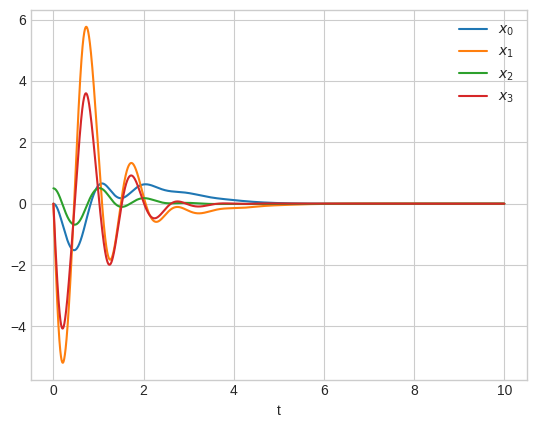

In [76]:
nonlin_lmi_full(np.array([0, 0, 0.5, 0]))

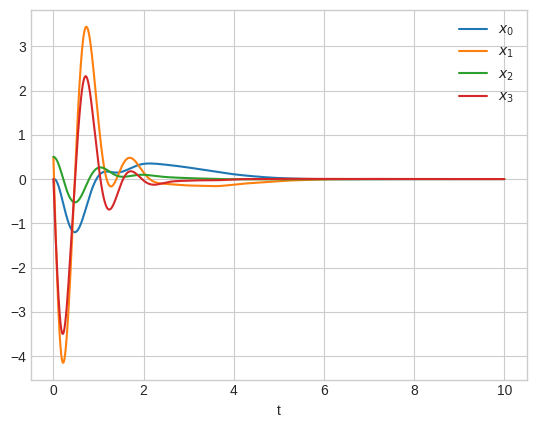

In [77]:
nonlin_lmi_full(np.array([0, 0.5, 0.5, 0]))

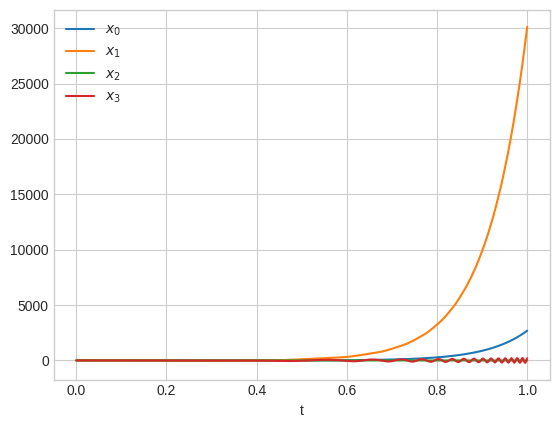

In [78]:
nonlin_lmi_full(np.array([0, 0.5, 1, 0]), get_t(1))

### Task 5

In [79]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    

\[Q = 0.1; R = 10.0; K_0 = \begin{bmatrix}
 -0.10 & -1.55 &  224.67 &  68.57
\end{bmatrix}\]
\[eig(A+BK_0) = \begin{bmatrix}
 -0.07 + 0.07j & -0.07 + -0.07j & -3.29 + 0.00j & -3.28 + 0.00j
\end{bmatrix}\]
\[Q = 1.0; R = 1.0; K_1 = \begin{bmatrix}
 -1.00 & -5.41 &  246.16 &  75.45
\end{bmatrix}\]
\[eig(A+BK_1) = \begin{bmatrix}
 -0.22 + 0.21j & -0.22 + -0.21j & -3.33 + 0.00j & -3.24 + 0.00j
\end{bmatrix}\]
\[Q = 10.0; R = 0.1; K_2 = \begin{bmatrix}
 -10.00 & -24.11 &  343.62 &  107.01
\end{bmatrix}\]
\[eig(A+BK_2) = \begin{bmatrix}
 -3.83 + 0.00j & -2.84 + 0.00j & -0.81 + 0.50j & -0.81 + -0.50j
\end{bmatrix}\]


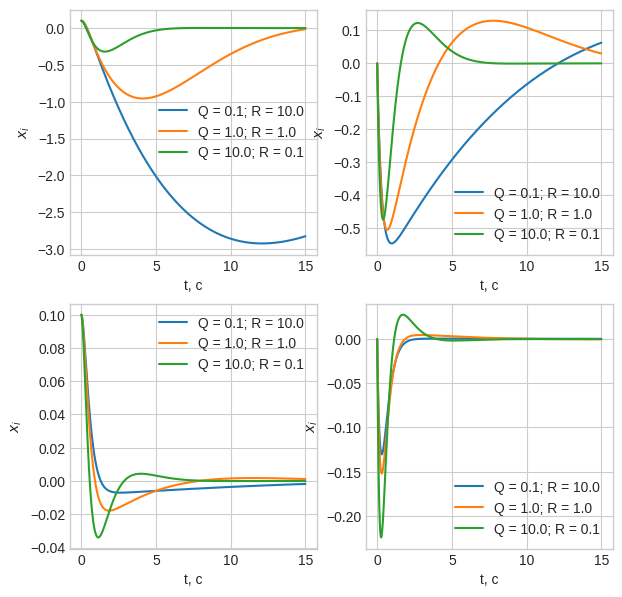

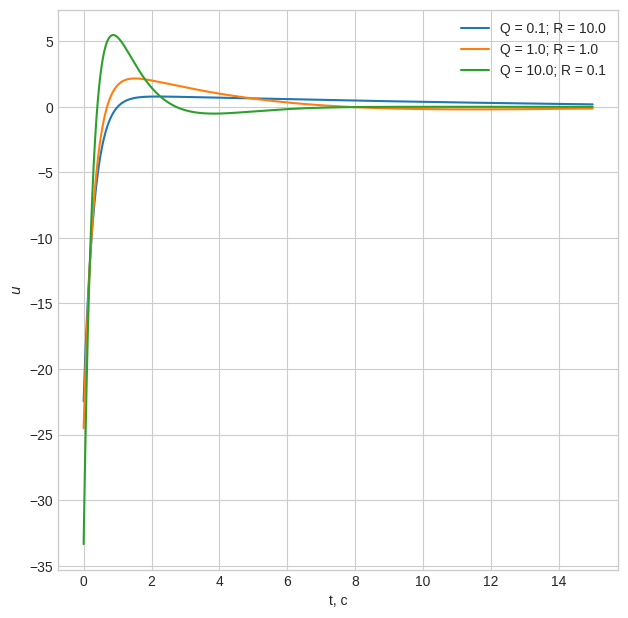

In [80]:
x0 = [0.1, 0, 0.1, 0]
values = np.array([1e-1, 1, 1e1])
ts = get_t(15)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
fig_u, axs_u = plt.subplots(1, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for indx in range(values.shape[0]):
    # print(f'======= Q = {values[indx]}; R = {values[::-1][indx]} ===========')
    Q = np.diag(np.ones((A.shape[0]))) * values[indx]
    R = np.diag(np.ones((B.shape[1]))) * values[::-1][indx]
    K, S, E = ctrl.lqr(A, B, Q, R)
    print(f'\[Q = {values[indx]}; R = {values[::-1][indx]}; K_{indx} = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[eig(A+BK_{indx}) = {a2l.to_ltx(E, print_out=False)}\]')
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": -K})
    ss_non_lin.set_inputs(2)    
    
    res = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0)
    
    xs = res.states
    us = (- K @ xs).reshape(-1)
    
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'Q = {values[indx]}; R = {values[::-1][indx]}') 
    axs_u.plot(ts, us, label=f'Q = {values[indx]}; R = {values[::-1][indx]}')
for i, state in enumerate(res.states):
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_xlabel('t, c')
        axs[i//2, i%2].set_ylabel('$x_i$')
axs_u.legend()
axs_u.set_xlabel('t, c')
axs_u.set_ylabel('$u$')
fig.savefig(f'{SAVE_PATH}/task5_states.jpg')
fig_u.savefig(f'{SAVE_PATH}/task5_us.jpg')

5.3

In [81]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])

In [82]:
def up_func_K_f(t, x, u, params):
    ''' 
    u -- trash
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]

    dx =  np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    D = params.get('D', np.zeros((1, 4)))
    std_f = params.get('std_f', 1)
    noise = np.random.normal(0, std_f, (1, 1))
    f = (D @ noise).reshape(-1)
    dx += f
    
    return dx
    
def up_func_LQE(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)
    
def generate_Kalman(a, c, std_q, std_r):
    q, r = np.diag(std_q)**2, np.diag(std_r)**2
    # q, r = np.linalg.inv(q), np.linalg.inv(r)
    l, p, _ = ctrl.lqe(a, np.eye(4), c, q, r)
    print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(l, print_out=False)}\]')
    return l

In [84]:
std_q, std_r = [0.01] * 4, [0.01] * 2
L = generate_Kalman(A, C, std_q, std_r)
x0 = np.array([0.1, 0, 0.1, 0])
ss_non_lin_f = ctrl.NonlinearIOSystem(up_func_K_f, params={"D": D, "std_f": std_q[0], 'K': -K})
ss_non_lin_f.set_inputs(2)
resp_non_lin_f = ctrl.input_output_response(ss_non_lin_f, T=ts, X0=x0, U=np.zeros((2, len(ts))))

ss_non_lin_LQE = ctrl.NonlinearIOSystem(up_func_LQE, params={"L": -L, "C": C})
ss_non_lin_LQE.set_inputs(2)

resp_non_lin_LQE = ctrl.input_output_response(ss_non_lin_LQE, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin_f.states)
err = resp_non_lin_LQE.states - resp_non_lin_f.states
for i in range(4):
    plt.plot(ts, err[i], label=f'$e_{i}$') 
    plt.xlabel('t') 
    plt.grid() 
    plt.legend() 
    plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
    plt.savefig(f'{SAVE_PATH}/task5_3.jpg')
plt.close()

\[Q = 0.01; R = 0.01; L = \begin{bmatrix}
  1.76 &  0.37\\
  1.11 &  1.84\\
  0.37 &  6.63\\
  1.23 &  21.54
\end{bmatrix}\]


5.4

\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
  1.76 &  0.37\\
  1.11 &  1.84\\
  0.37 &  6.63\\
  1.23 &  21.54
\end{bmatrix}\]
\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
 -1.76 & -0.37\\
 -1.11 & -1.84\\
 -0.37 & -6.63\\
 -1.23 & -21.54
\end{bmatrix}\]
\[spec(A+LC) = \begin{bmatrix}
 -0.87 + 0.50j & -0.87 + -0.50j & -2.85 + 0.00j & -3.80 + 0.00j
\end{bmatrix}\]
\[Q = 1; R = 1; K= \begin{bmatrix}
  1.00 &  5.41 & -246.16 & -75.45
\end{bmatrix}\]
\[spec(A + BK) = \begin{bmatrix}
 -0.22 + 0.21j & -0.22 + -0.21j & -3.33 + 0.00j & -3.24 + 0.00j
\end{bmatrix}\]


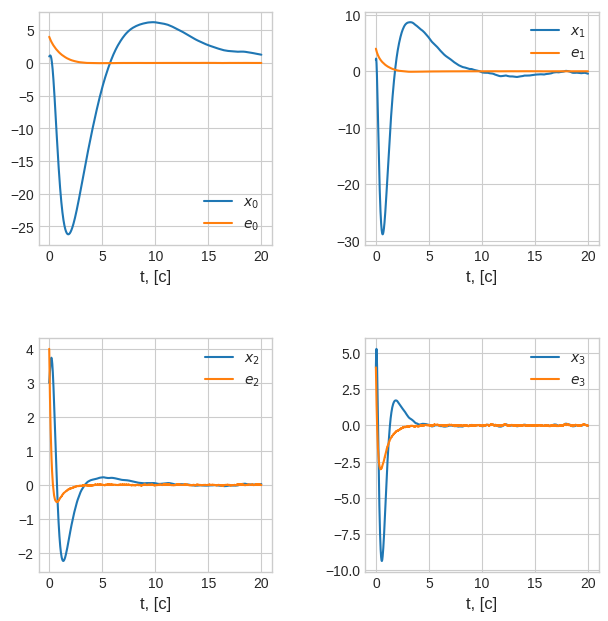

In [85]:
std_q, std_r = [0.1] * 4, [0.1] * 2
L = -generate_Kalman(A, C, std_q, std_r)
print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A+LC) = {a2l.to_ltx(np.linalg.eigvals(A + L @ C), print_out=False)}\]')


Q = np.diag(np.ones((A.shape[0]))) * 1
R = np.diag(np.ones((B.shape[1]))) * 1
K, S, E = ctrl.lqr(A, B, Q, R)
K = -K
print(f'\[Q = {1}; R = {1}; K= {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + BK) = {a2l.to_ltx(E, print_out=False)}\]')

new_A = np.block([[A + B @ K, -B @ K], [np.zeros((A.shape[0], K.shape[1] * 2 - C.shape[1])), A + L @ C]])
new_B = np.block([[np.diag([1] * 4), np.zeros((4, 2))], [np.diag([1] * 4), L]])

ts = get_t(20)

f, xi = np.random.normal(0, std_q, (len(ts), 4)), np.random.normal(0, std_r, (len(ts), 2))
u = np.hstack([f, xi])
ss = ctrl.ss(new_A, new_B, 0 * new_A, 0 * new_B)
resp = ctrl.forced_response(ss, T=ts, U=u.T, X0=np.array([1, 2, 3, 4, 4, 4, 4, 4]))

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for i, state in enumerate(resp.states[:4]):
        axs[i//2, i%2].plot(ts, state, label=f'$ x_{i} $') 
        axs[i//2, i%2].plot(ts, resp.states[4 + i], label=f'$ e_{i} $') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
#     axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task5_LQG_lin.jpg')

5.5

In [86]:
def up_func_LQG(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    D = params.get('D', np.zeros((1, 4)))
    std_f = params.get('std_f', 1)
    noise = np.random.normal(0, std_f, (1, 1))
    f = (D @ noise).reshape(-1)
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + f
    
    return np.hstack((dx, dxh))

In [87]:
x0 = np.array([0.1, 0, 0.1, 0])
std_q, std_r = [0.1] * 4, [0.1] * 2
L = -generate_Kalman(A, C, std_q, std_r)
print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A+LC) = {a2l.to_ltx(np.linalg.eigvals(A + L @ C), print_out=False)}\]')


Q = np.diag(np.ones((A.shape[0]))) * 1
R = np.diag(np.ones((B.shape[1]))) * 1
K, S, E = ctrl.lqr(A, B, Q, R)
K = -K
print(f'\[Q = {1}; R = {1}; K= {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + BK) = {a2l.to_ltx(E, print_out=False)}\]')

ss_non_lin_LQG = ctrl.NonlinearIOSystem(up_func_LQG, params={"L": L, "C": C, "D": D, "std_f": std_q[0], 'K': K})
ss_non_lin_LQG.set_inputs(2)

resp_non_lin_LQG= ctrl.input_output_response(ss_non_lin_LQG, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=np.zeros((2, len(ts))))

\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
  1.76 &  0.37\\
  1.11 &  1.84\\
  0.37 &  6.63\\
  1.23 &  21.54
\end{bmatrix}\]
\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
 -1.76 & -0.37\\
 -1.11 & -1.84\\
 -0.37 & -6.63\\
 -1.23 & -21.54
\end{bmatrix}\]
\[spec(A+LC) = \begin{bmatrix}
 -0.87 + 0.50j & -0.87 + -0.50j & -2.85 + 0.00j & -3.80 + 0.00j
\end{bmatrix}\]
\[Q = 1; R = 1; K= \begin{bmatrix}
  1.00 &  5.41 & -246.16 & -75.45
\end{bmatrix}\]
\[spec(A + BK) = \begin{bmatrix}
 -0.22 + 0.21j & -0.22 + -0.21j & -3.33 + 0.00j & -3.24 + 0.00j
\end{bmatrix}\]


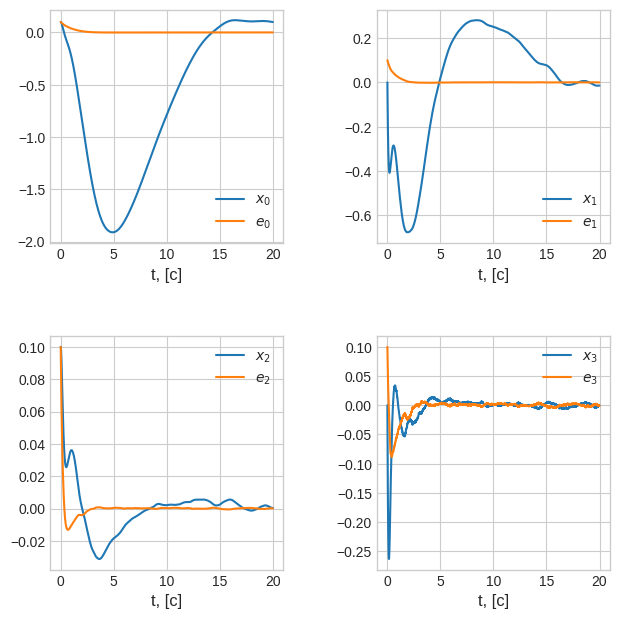

In [88]:
fig, axs = plt.subplots(2, 2,figsize=(7,7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for i, state in enumerate(resp.states[:4]):
        axs[i//2, i%2].plot(ts, resp_non_lin_LQG.states[i], label=f'$ x_{i} $') 
        axs[i//2, i%2].plot(ts, resp_non_lin_LQG.states[i + 4] - resp_non_lin_LQG.states[i], label=f'$ e_{i} $') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
#     axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task5_LQG_non_lin.jpg')

## Task 6

6.1

In [89]:
A_1 = A

B_1 = B

B_2 = D @ (np.array(list(range(4))) / 3).reshape((1,-1))

A_2 = np.array([
    [0, 2, 0, 0],
    [-2, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0],
])

C_1 = C

D_1 = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])

C_2 = np.array([[0, 0, 1, 0]])

D_2 = np.array([[0, 0, 0, 0]])

In [90]:
P_1 = cp.Variable((A_1.shape[0],D_2.shape[1]))
Y_1 = cp.Variable((B_1.shape[1],B_2.shape[1])) 
prob = cp.Problem(cp.Maximize(0),[C_2 @ P_1 + D_2 == 0, P_1 @ A_2 - A_1 @ P_1 == B_1 @ Y_1 + B_2])
prob.solve(solver="CLARABEL")

0.0

In [91]:
ts = get_t()
w_sys = ctrl.ss(A_2, np.zeros((4,1)), np.zeros((1, 4)), 0)
w = ctrl.initial_response(w_sys, X0=[0.5, 0.5, 0.5, 0.5], T=ts).states

In [92]:
B_2

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03333333, 0.06666667, 0.1       ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.36666667, 0.73333333, 1.1       ]])

In [93]:
Y = np.ones((B.shape[1], A.shape[0]))
G = np.diag([-1, -2, -3, -4])
K_1 = task32_get_K(A_1, B_1, G, Y)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))

K_2 = Y_1.value - K_1 @ P_1.value
K_2

array([[  8.50340136,  -5.70748299,   7.85941043, -25.05895692]])

In [94]:
def up_func_comp(t, x, u, params):
    w = u.copy()
    f = ((np.array(list(range(4))) / 3).reshape((1,-1)) @ w).reshape(-1)[0]
    u = (K_1@x + K_2@w).reshape(-1)[0]
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u + f*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*f/(m*l**2) + u*np.cos(x[2])/l)
    ]) 
    return dx
    
non_lin_sys_comp = ctrl.NonlinearIOSystem(up_func_comp)
non_lin_sys_comp.set_inputs(4)

In [95]:
def compare_comp(x0):
    non_lin_sys_comp = ctrl.NonlinearIOSystem(up_func_comp)
    non_lin_sys_comp.set_inputs(4)
    resp_non_lin_comp = ctrl.input_output_response(non_lin_sys_comp, T=ts, X0=x0, U=w)
    lin_sys_comp = ctrl.ss(A_1 + B_1@K_1, B_2 + B_1@K_2, C_2, D_2)
    resp_lin_comp= ctrl.input_output_response(lin_sys_comp, T=ts, X0=x0, U=w)
    plt.plot(ts, resp_non_lin_comp.states[2], label="nonlinear")
    plt.plot(ts, resp_lin_comp.states[2], "--", label="linear")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task6_1_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

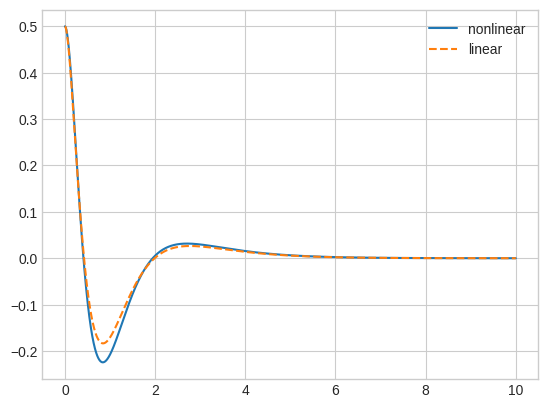

In [96]:
compare_comp(np.array([0.1, 0, 0.5, 0]))

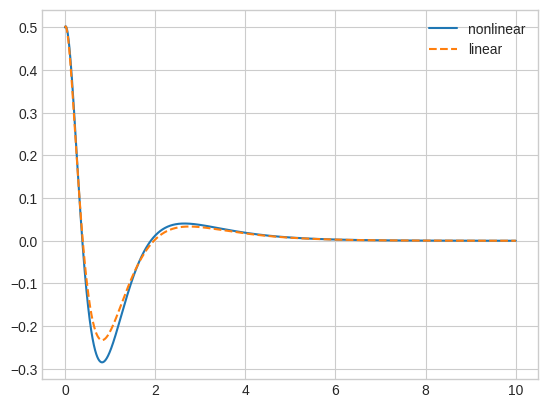

In [97]:
compare_comp(np.array([0, 0, 0.5, 0.3]))

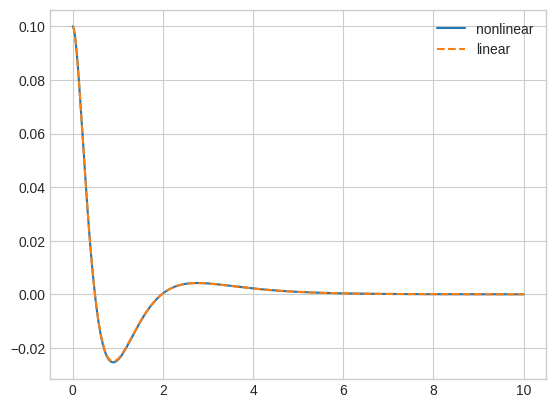

In [98]:
compare_comp(np.array([0.1, 0, 0.1, 0]))

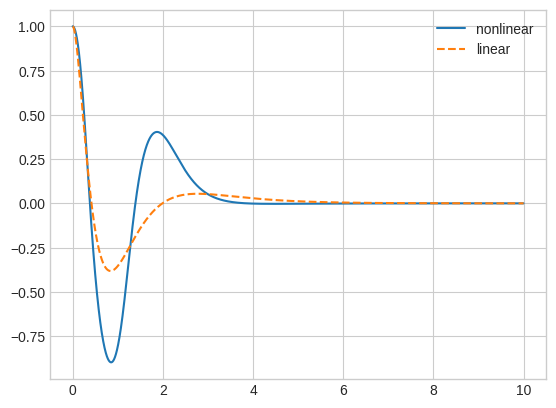

In [99]:
compare_comp(np.array([0.1, 0, 1, 0]))

6.2

In [100]:
A_1 = A

B_1 = B

B_2 = np.zeros((4,4))

A_2 = np.array([
    [0, 2, 0, 0],
    [-2, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0],
])

C_2 = np.array([[0, 0, 1, 0]])

D_2 = np.array([[0.1, 0.1, 0.1, 0.1]])

In [101]:
P_1 = cp.Variable((A_1.shape[0],D_2.shape[1]))
Y_1 = cp.Variable((B_1.shape[1],B_2.shape[1])) 
prob = cp.Problem(cp.Maximize(0),[C_2 @ P_1 + D_2 == 0, P_1 @ A_2 - A_1 @ P_1 == B_1 @ Y_1 + B_2])
prob.solve(solver="CLARABEL")

0.0

In [102]:
ts = get_t()
w_sys = ctrl.ss(A_2, np.zeros((4,1)), np.zeros((1, 4)), 0)
w = ctrl.initial_response(w_sys, X0=[0.5, 0.2, 0.5, 0.2], T=ts).states

In [103]:
Y = np.ones((B.shape[1], A.shape[0]))
G = np.diag([-1, -2, -3, -4])
K_1 = task32_get_K(A, B, G, Y)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))

K_2 = Y_1.value - K_1 @ P_1.value
K_2

array([[-30.        , -20.        , -10.        , -36.66666667]])

In [104]:
def up_func_track(t, x, u, params):
    w = u.copy()
    f = 0
    u = (K_1@x + K_2@w).reshape(-1)[0]
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u + f*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*f/(m*l**2) + u*np.cos(x[2])/l)
    ]) 
    return dx

In [105]:
def compare_track(x0):
    non_lin_sys_track = ctrl.NonlinearIOSystem(up_func_track)
    non_lin_sys_track.set_inputs(4)
    resp_non_lin_track= ctrl.input_output_response(non_lin_sys_track, T=ts, X0=x0, U=w)
    lin_sys_track = ctrl.ss(A_1 + B_1@K_1, B_2 + B_1@K_2, C_2, D_2)
    resp_lin_track= ctrl.input_output_response(lin_sys_track, T=ts, X0=x0, U=w)
    plt.plot(ts, -(D_2@w)[0], label="target")
    plt.plot(ts, resp_non_lin_track.states[2], label="nonlinear")
    plt.plot(ts, resp_lin_track.states[2], "--", label="linear")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task6_2_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

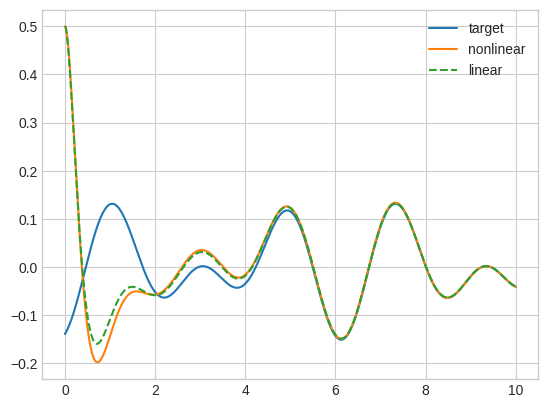

In [106]:
compare_track(np.array([0.1, 0, 0.5, 0]))

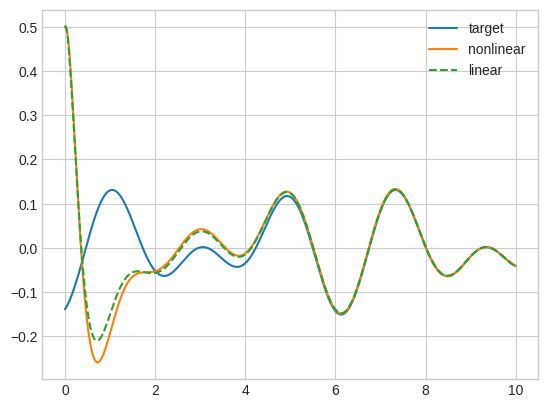

In [107]:
compare_track(np.array([0, 0, 0.5, 0.3]))

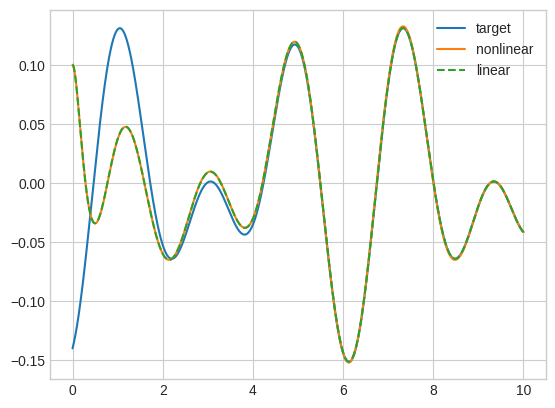

In [108]:
compare_track(np.array([0.1, 0, 0.1, 0]))

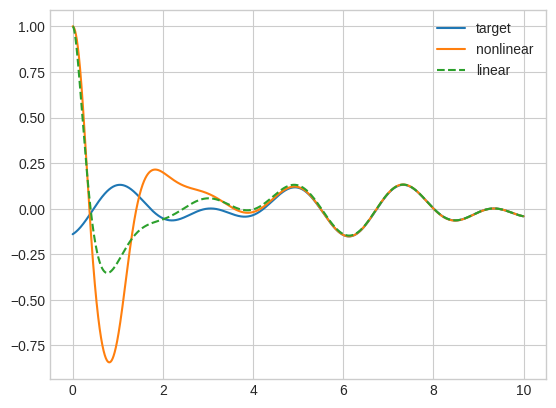

In [109]:
compare_track(np.array([0.1, 0, 1, 0]))